In [1]:
%%html
<link rel="stylesheet" type="text/css" href="rise.css" />

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['lines.markeredgecolor'] = 'w'
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['figure.figsize'] = [8, 6]

# Generalized linear model (GLM)
**Learning goals**
- You will gain a conceptual understanding for a generalized linear model.
- You will appreciate why a GLM may be a better choice than a simple linear model for neural spiking data.
- You will use a GLM (poisson regression) to predict a neuron's spiking in response to a stimulus.
- You will see how the choice of noise distribution in a GLM can be used for binary classification.
- You will use a GLM (logistic regression) to predict a mouse's left vs. right choice from its neural activity.

Linear Regression

![](images/normal-glm.png)

Is linear regression a good choice for this data?

Why or why not?

![](images/poisson-data.png)

What if $Y$ is the number of counts of something (e.g., # of spikes)?

Is linear regression appropriate?

![](images/poisson-data.png)

**Linear Model**

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$

$y = Normal(\hat{y}, \sigma)$

**Generalized Linear Model**

$\hat{y} = f(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n)$

* $f$ can be a nonlinear function (e.g., $exp$)

$y = probdist(\hat{y})$

* $probdist$ is a probability distribution that need not be normal

![](images/GLM-diagram.png)

![](images/poisson-logistic-diagram.png)

**Poisson GLM**

$\hat{y} = exp(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n)$

$y = Poisson(\hat{y})$

* Only non-negative integer counts
* The variance will increase with the number of counts

![](images/poisson-glm.png)

**Bernoulli GLM = Logistic Regression**

$\hat{y} = sigmoid(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n)}}$

$y = Bernoulli(\hat{y})$

* Only 0 or 1
* This is a binary classifier

![](images/bernoulli-glm.png)

### Poisson GLM for spiking neuron

Modeling a retinal ganglion cell spike train by fitting a temporal receptive field.

Adapted from [Neuromatch Academy](https://neuronline.sfn.org/scientific-research/tutorial-1-generalized-linear-models)

In [3]:
# data from Jonathan Pillow's lab: https://github.com/pillowlab/GLMspiketraintutorial
stimulus = np.load('data/retinal_ganglion_stimulus.npy')
spikes = np.load('data/retinal_ganglion_spikes.npy')

stimulus.shape, spikes.shape

((20000,), (20000,))

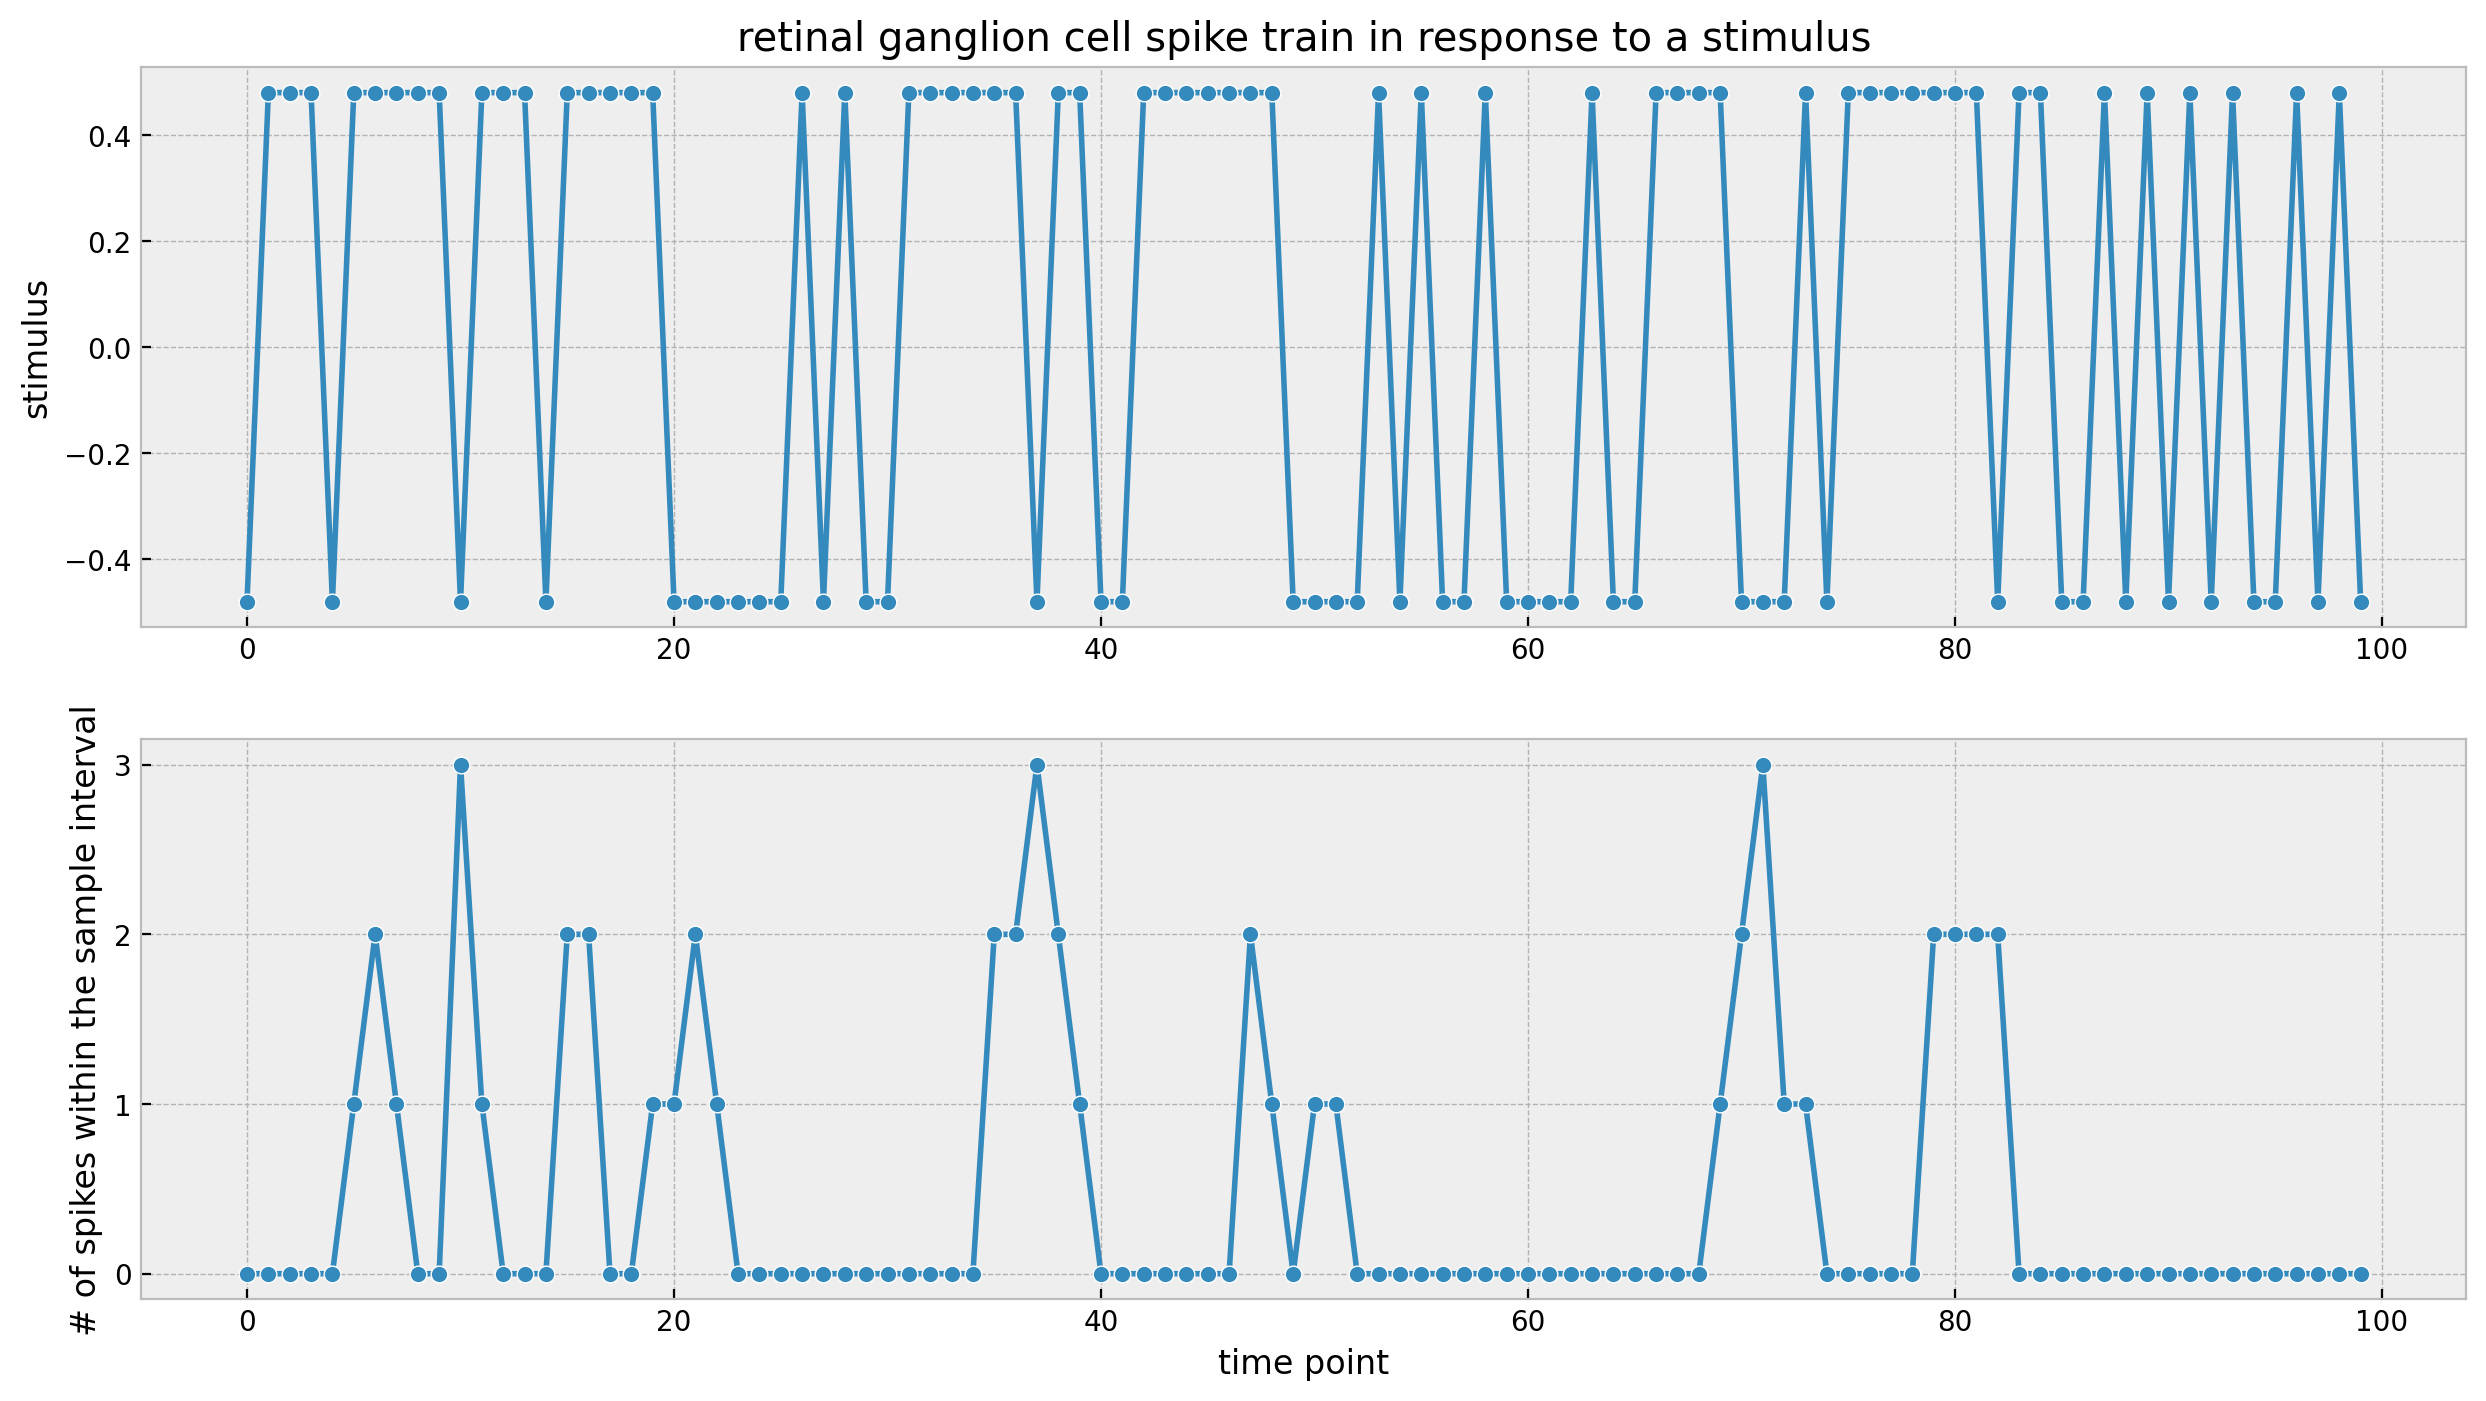

In [4]:
# retinal ganglion stimulus and spike data
plt.figure(figsize=[15,8])
plt.subplot(211)
plt.plot(stimulus[:100], 'o-')
plt.ylabel('stimulus')
plt.title('retinal ganglion cell spike train in response to a stimulus')
plt.subplot(212)
plt.plot(spikes[:100], 'o-')
plt.yticks(range(4))
plt.ylabel('# of spikes within the sample interval')
plt.xlabel('time point');

Let's build a model that will predict the cell's spiking activity based on the preceeding stimulus.

How might you construct a linear model that predicts the number of spikes in each sample interval based on the temporally preceding stimulus (e.g., the last 25 time points).

For example, at every time point $t$, you might predict the number of spikes within that sample interval based on a linear combination of the stimulus over the preceding 25 time points (including time point $t$).

$number\ of\ spikes(t) = \beta_0 + \beta_1 stimulus(t-24) + \beta_2 stimulus(t-23) + ... + \beta_{25} stimulus(t)$

This is a simple linear model:

$\hat{y}_t = \beta_0 + \beta_1 x_{t-24} + \beta_2 x_{t-23} + ... + \beta_{25} x_{t}$

Extending the relation $\hat{y}_t = \beta_0 + \beta_1 x_{t-24} + \beta_2 x_{t-23} + ... + \beta_{25} x_{t}$ to every time point $t$ gives:

$\begin{bmatrix} \vdots \\ \hat{y}_t \\ \vdots \end{bmatrix} = \beta_0 + \beta_1 \begin{bmatrix} \vdots \\ x_{t-24} \\ \vdots \end{bmatrix} + \beta_2 \begin{bmatrix} \vdots \\ x_{t-23} \\ \vdots \end{bmatrix} + \dots + \beta_{25} \begin{bmatrix} \vdots \\ x_t \\ \vdots \end{bmatrix}$

$X = 
\begin{bmatrix} 
\vdots & \vdots & & \vdots \\ 
x_{t-24} & x_{t-23} & \dots & x_t \\ 
\vdots & \vdots & & \vdots 
\end{bmatrix}$

<img src="images/X-linear-receptive-field.drawio.svg" width="50%">

<img src="images/X-linear-receptive-field-0.drawio.svg" width="50%">

<img src="images/X-linear-receptive-field-1.drawio.svg" width="50%">

<img src="images/X-linear-receptive-field-2.drawio.svg" width="50%">

<img src="images/X-linear-receptive-field-3.drawio.svg" width="50%">

<img src="images/X-linear-receptive-field-11.drawio.svg" width="50%">

<img src="images/X-linear-receptive-field-12.drawio.svg" width="50%">

<img src="images/X-linear-receptive-field-13.drawio.svg" width="50%">

<img src="images/X-linear-receptive-field-last.drawio.svg" width="50%">

Construct $X$: 

In [5]:
def stimulus_to_X(stimulus):
    T = len(stimulus)
    X = np.zeros((T, 25))
    for t in range(T):
        if t < 24:
            X[t,-t-1:] = stimulus[:t+1]  # last t columns of row t
        else:
            X[t,:] = stimulus[t-24:t+1]  # full row t
    return X

X = stimulus_to_X(stimulus)
y = spikes

X.shape, y.shape

((20000, 25), (20000,))

In [6]:
import pandas as pd
pd.DataFrame(X, index=[f"t={t}" for t in range(len(stimulus))], 
             columns=[fr"$\Delta$t={dt}" for dt in range(-24,1)])

$\Delta$t=-24  $\Delta$t=-23  $\Delta$t=-22  $\Delta$t=-21  \
t=0               0.00           0.00           0.00           0.00   
t=1               0.00           0.00           0.00           0.00   
t=2               0.00           0.00           0.00           0.00   
t=3               0.00           0.00           0.00           0.00   
t=4               0.00           0.00           0.00           0.00   
...                ...            ...            ...            ...   
t=19995          -0.48           0.48           0.48           0.48   
t=19996           0.48           0.48           0.48           0.48   
t=19997           0.48           0.48           0.48          -0.48   
t=19998           0.48           0.48          -0.48          -0.48   
t=19999           0.48          -0.48          -0.48           0.48   

         $\Delta$t=-20  $\Delta$t=-19  $\Delta$t=-18  $\Delta$t=-17  \
t=0               0.00           0.00           0.00           0.00   
t=1               0.00           0.00           0.00           0.00   
t=2               0.00           0.00           0.00           0.00   
t=3               0.00           0.00           0.00           0.00   
t=4               0.00           0.00           0.00           0.00   
...                ...            ...            ...            ...   
t=19995           0.48          -0.48          -0.48           0.48   
t=19996          -0.48          -0.48           0.48          -0.48   
t=19997          -0.48           0.48          -0.48          -0.48   
t=19998           0.48          -0.48          -0.48          -0.48   
t=19999          -0.48          -0.48          -0.48          -0.48   

         $\Delta$t=-16  $\Delta$t=-15  ...  $\Delta$t=-9  $\Delta$t=-8  \
t=0               0.00           0.00  ...          0.00          0.00   
t=1               0.00           0.00  ...          0.00          0.00   
t=2               0.00           0.00  ...          0.00          0.00   
t=3               0.00           0.00  ...          0.00          0.00   
t=4               0.00           0.00  ...          0.00          0.00   
...                ...            ...  ...           ...           ...   
t=19995          -0.48          -0.48  ...          0.48          0.48   
t=19996          -0.48          -0.48  ...          0.48          0.48   
t=19997          -0.48          -0.48  ...          0.48         -0.48   
t=19998          -0.48          -0.48  ...         -0.48          0.48   
t=19999          -0.48          -0.48  ...          0.48          0.48   

         $\Delta$t=-7  $\Delta$t=-6  $\Delta$t=-5  $\Delta$t=-4  $\Delta$t=-3  \
t=0              0.00          0.00          0.00          0.00          0.00   
t=1              0.00          0.00          0.00          0.00          0.00   
t=2              0.00          0.00          0.00          0.00          0.00   
t=3              0.00          0.00          0.00          0.00         -0.48   
t=4              0.00          0.00          0.00         -0.48          0.48   
...               ...           ...           ...           ...           ...   
t=19995          0.48         -0.48          0.48          0.48         -0.48   
t=19996         -0.48          0.48          0.48         -0.48          0.48   
t=19997          0.48          0.48         -0.48          0.48          0.48   
t=19998          0.48         -0.48          0.48          0.48         -0.48   
t=19999         -0.48          0.48          0.48         -0.48          0.48   

         $\Delta$t=-2  $\Delta$t=-1  $\Delta$t=0  
t=0              0.00          0.00        -0.48  
t=1              0.00         -0.48         0.48  
t=2             -0.48          0.48         0.48  
t=3              0.48          0.48         0.48  
t=4              0.48          0.48        -0.48  
...               ...           ...          ...  
t=19995          0.48          0.48        -0.48  
t=19996          0.48         -0.

### Question

Should you standardize the columns of $X$?

Why or why not?

### Exercise

Fit a linear model that predicts the spike counts $y$ based on the preceding time windows $X$.

In [7]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

# fit the model to the data X, y
...

# predict the spike counts based on the stimulus
lin_spikes = ...

### Exercise key

Fit a linear model that predicts the spike counts $y$ based on the preceding time windows $X$.

In [8]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

# fit the model to the data X, y
lin_model.fit(X, y)

# predict the spike counts based on the stimulus
lin_spikes = lin_model.predict(X)

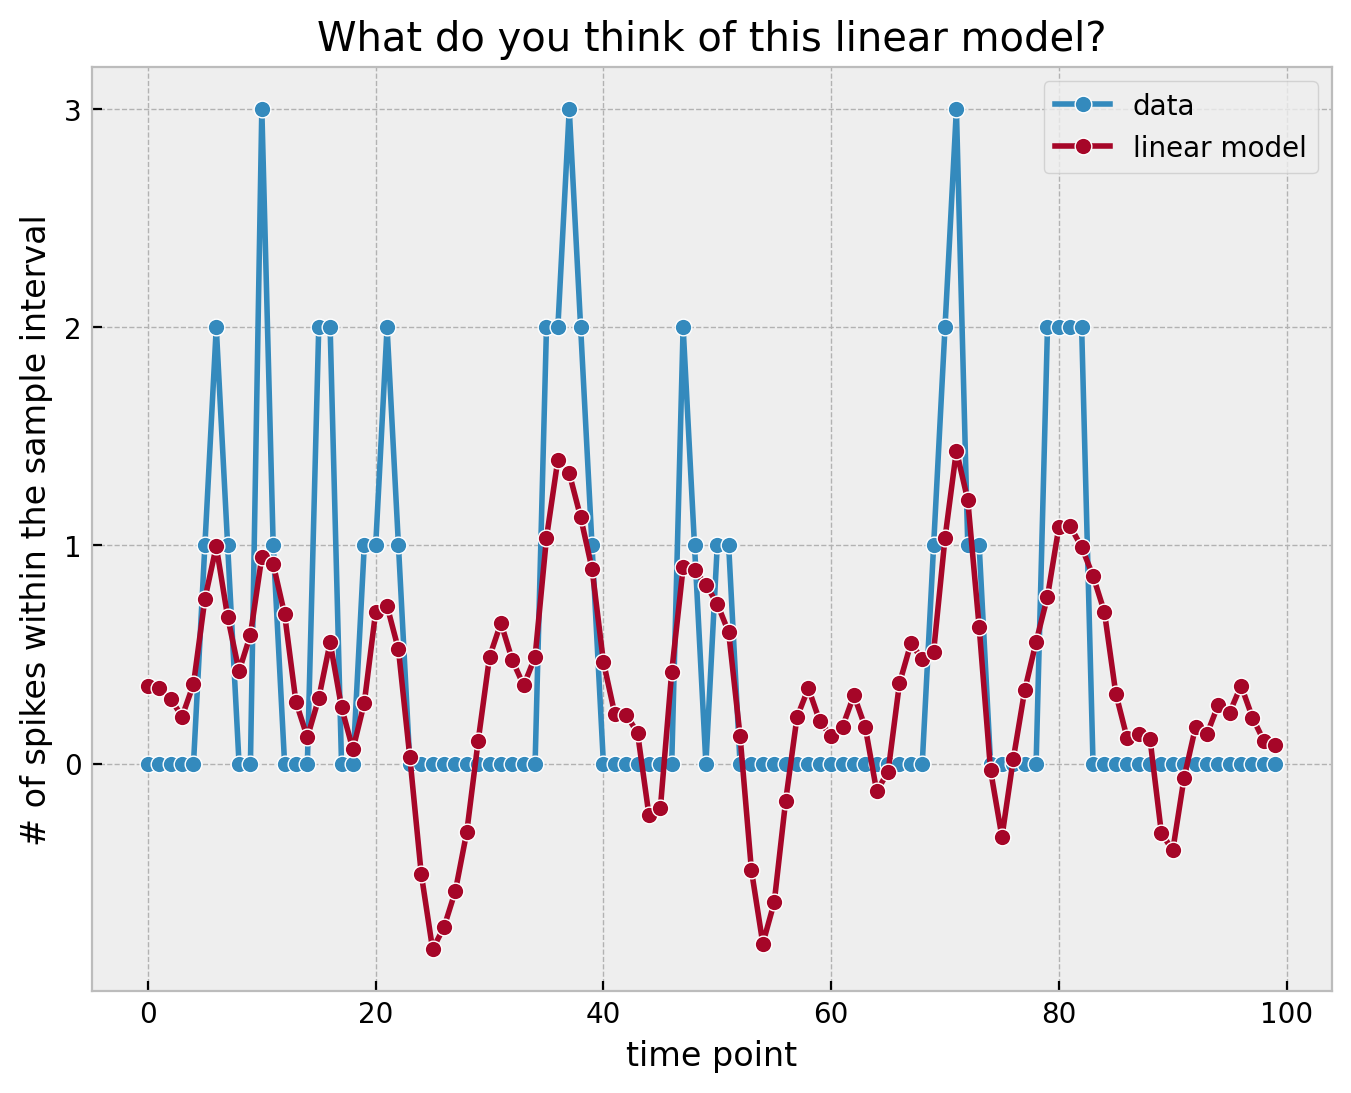

In [9]:
# linear model spike count prediction
plt.plot(spikes[:100], 'o-', label='data')
plt.plot(lin_spikes[:100], 'o-', label='linear model')
plt.yticks(range(4))
plt.ylabel('# of spikes within the sample interval')
plt.xlabel('time point')
plt.title('What do you think of this linear model?')
plt.legend();

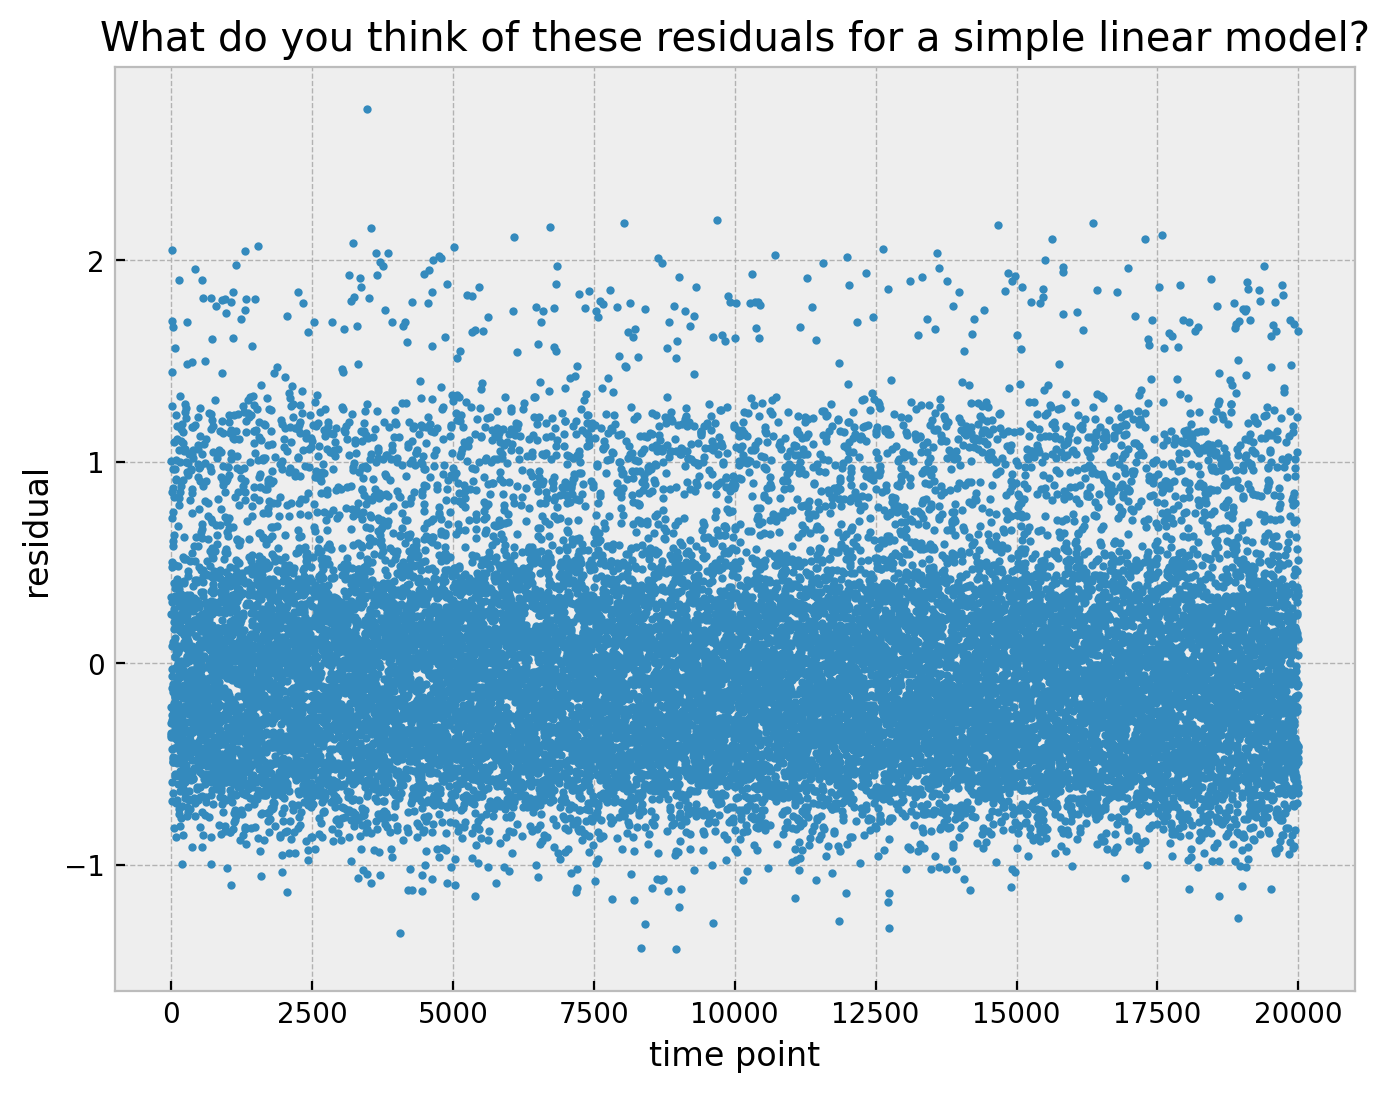

In [10]:
lin_residuals = spikes - lin_spikes

plt.plot(lin_residuals, '.', mew=0)
plt.xlabel('time point')
plt.ylabel('residual')
plt.title('What do you think of these residuals for a simple linear model?');

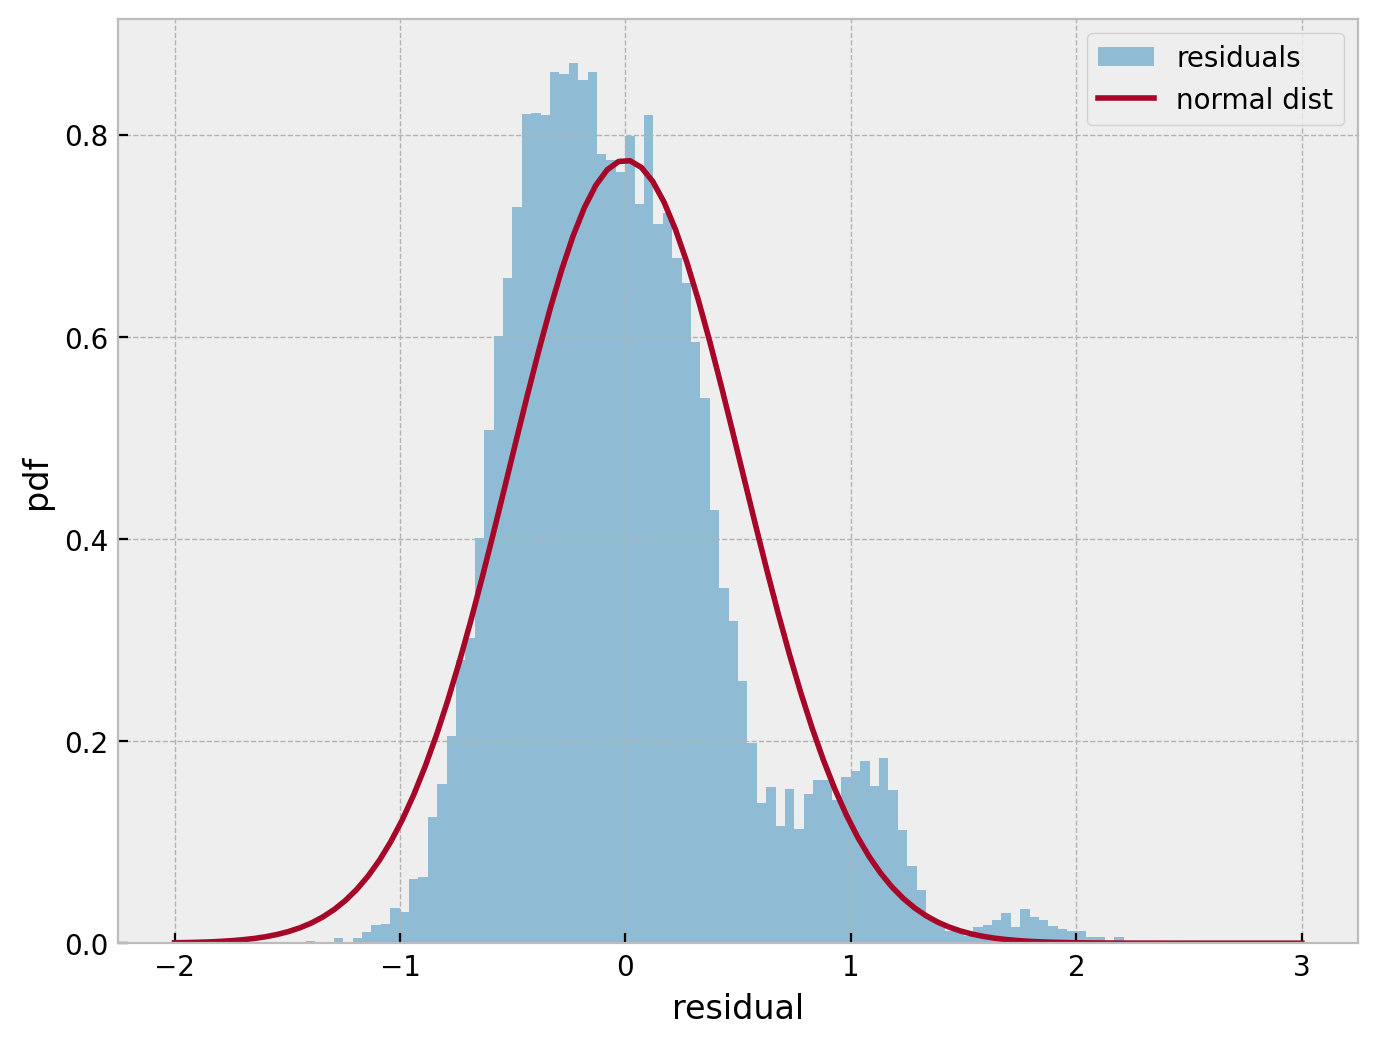

In [11]:
import scipy.stats as st

plt.hist(lin_residuals, 100, density=True, alpha=0.5, label='residuals')
plt.xlabel('residual')
plt.ylabel('pdf')

x = np.linspace(-2, 3, 100)
pdf = st.norm(lin_residuals.mean(), lin_residuals.std()).pdf(x)
plt.plot(x, pdf, label='normal dist')

plt.legend();

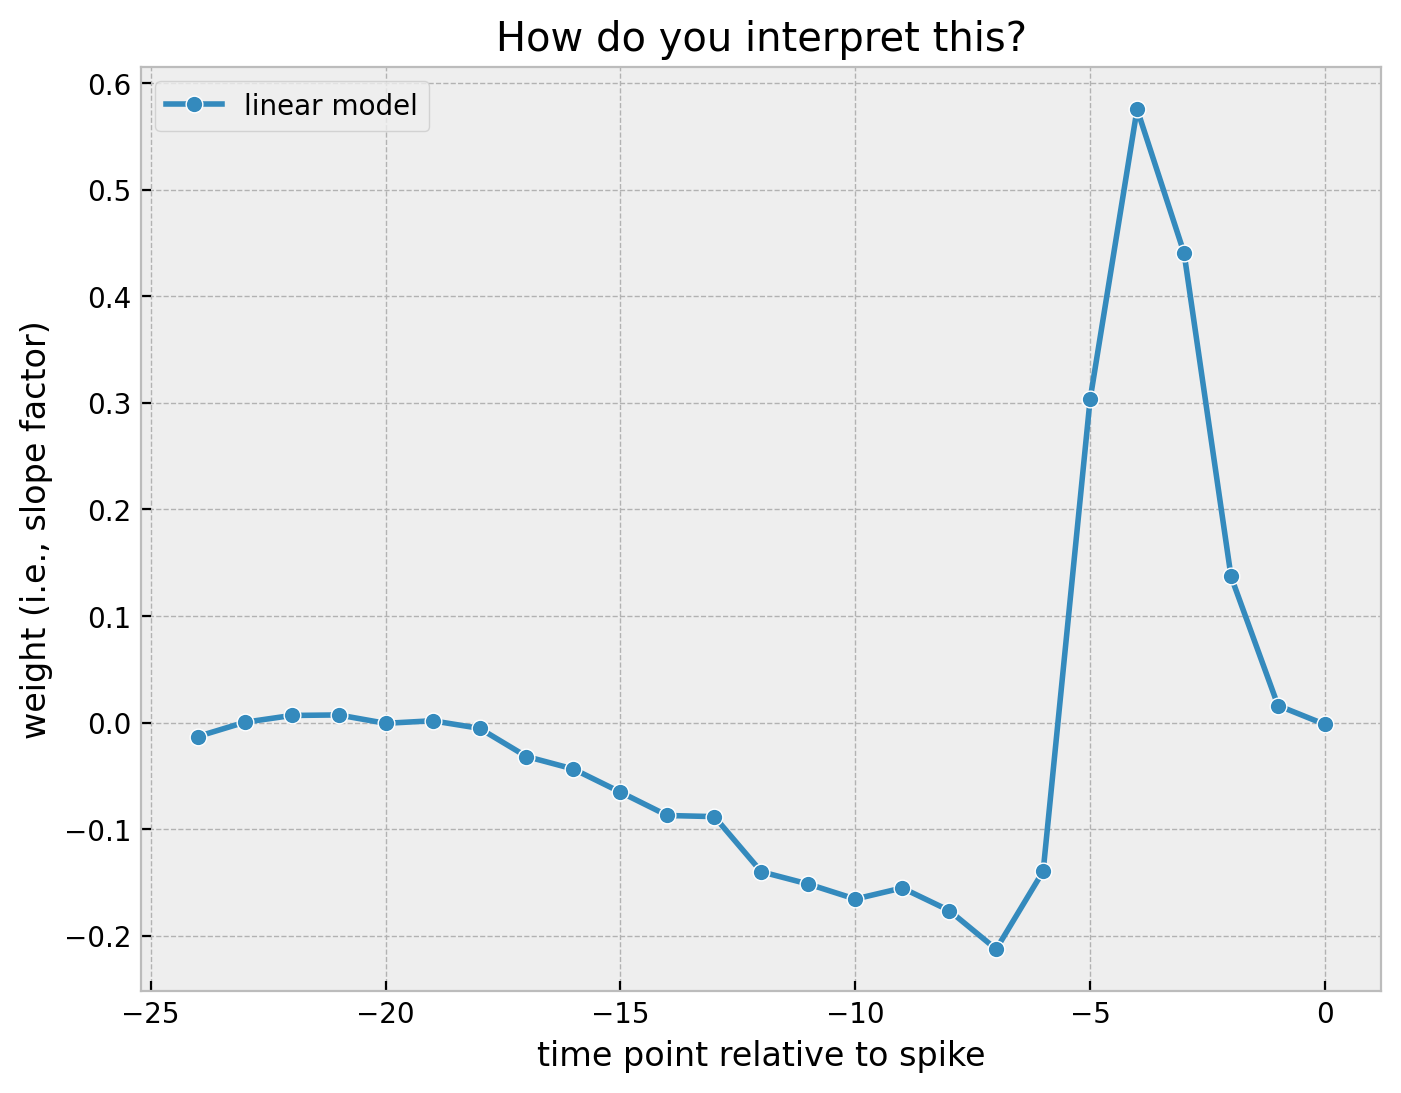

In [12]:
plt.plot(range(-24, 1), lin_model.coef_, 'o-', label='linear model')
plt.xlabel('time point relative to spike')
plt.ylabel('weight (i.e., slope factor)')
plt.title('How do you interpret this?')
plt.legend();

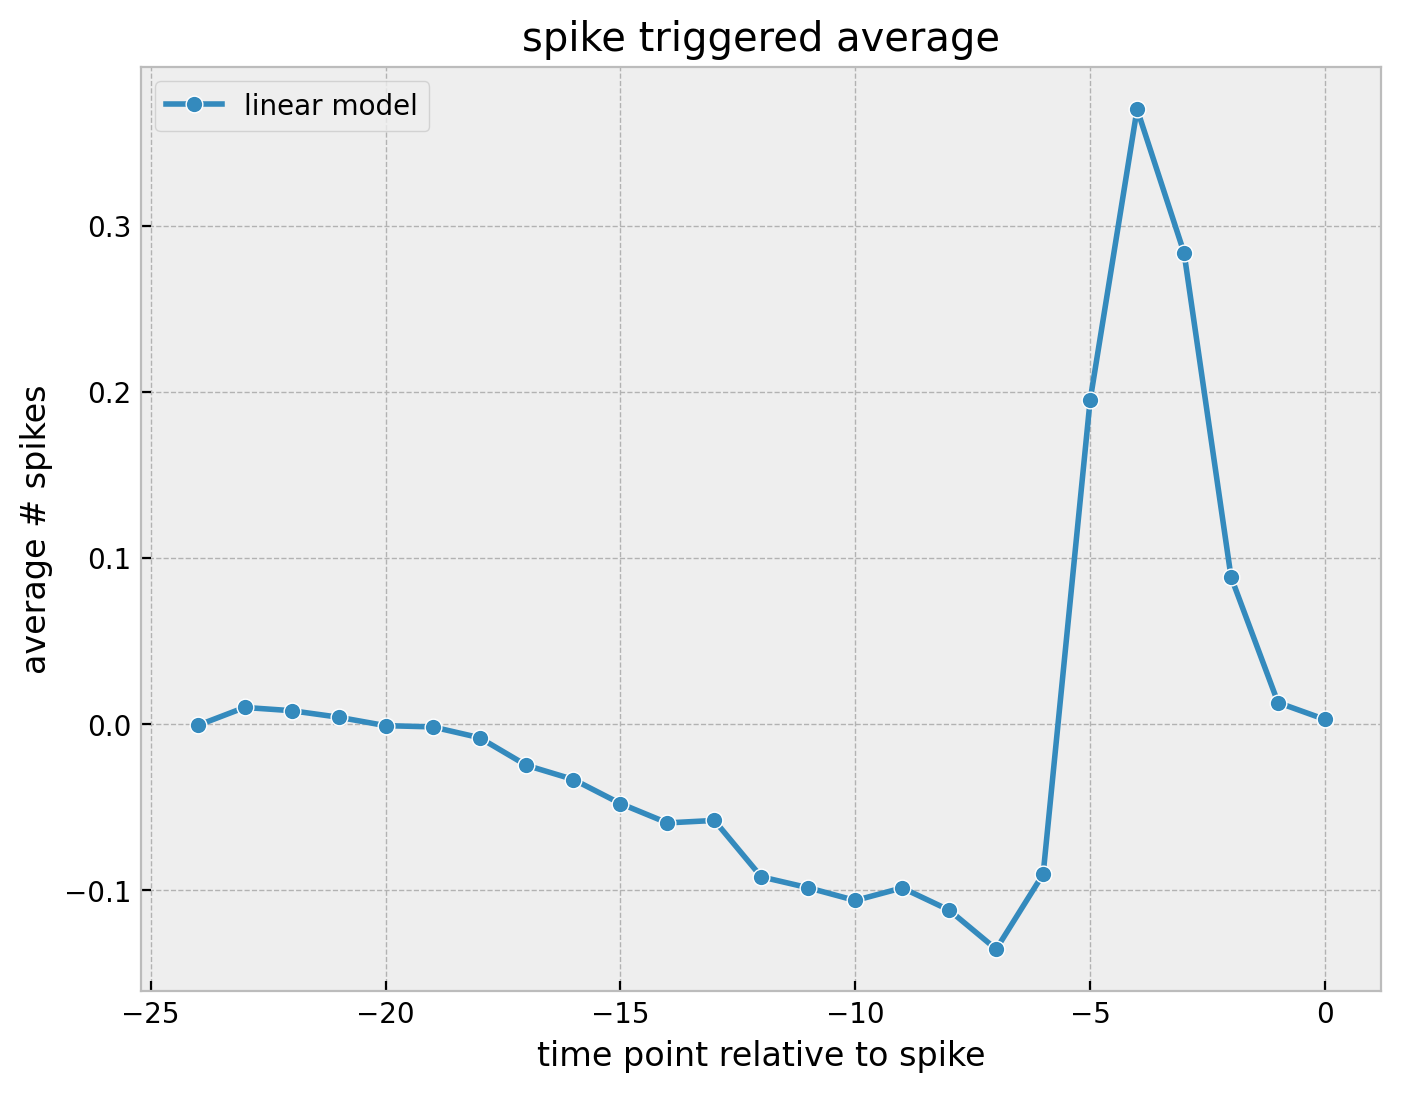

In [13]:
STA = X.T @ y / y.sum()

plt.plot(range(-24, 1), STA, 'o-', label='linear model')
plt.xlabel('time point relative to spike')
plt.ylabel('average # spikes')
plt.title('spike triggered average')
plt.legend();

Use a Poisson GLM to describe the spike rate as a function of the preceding stimulus.

$\hat{y}_t = exp(\beta_0 + \beta_1 x_{t-24} + \beta_2 x_{t-23} + ... + \beta_{25} x_{t})$

$y = \hat{y} + Poisson(\hat{y})$

The input $X$ is exactly the same as for the linear model.

$X = 
\begin{bmatrix} 
\vdots & \vdots & & \vdots \\ 
x_{t-24} & x_{t-23} & \dots & x_t \\ 
\vdots & \vdots & & \vdots 
\end{bmatrix}$

In [14]:
from sklearn.linear_model import PoissonRegressor

# alpha is a regularization strength
poisson_model = PoissonRegressor(alpha=0)

# fit the model to the data X, y
poisson_model.fit(X, y)

# predict the spike counts based on the stimulus
poisson_spikes = poisson_model.predict(X)

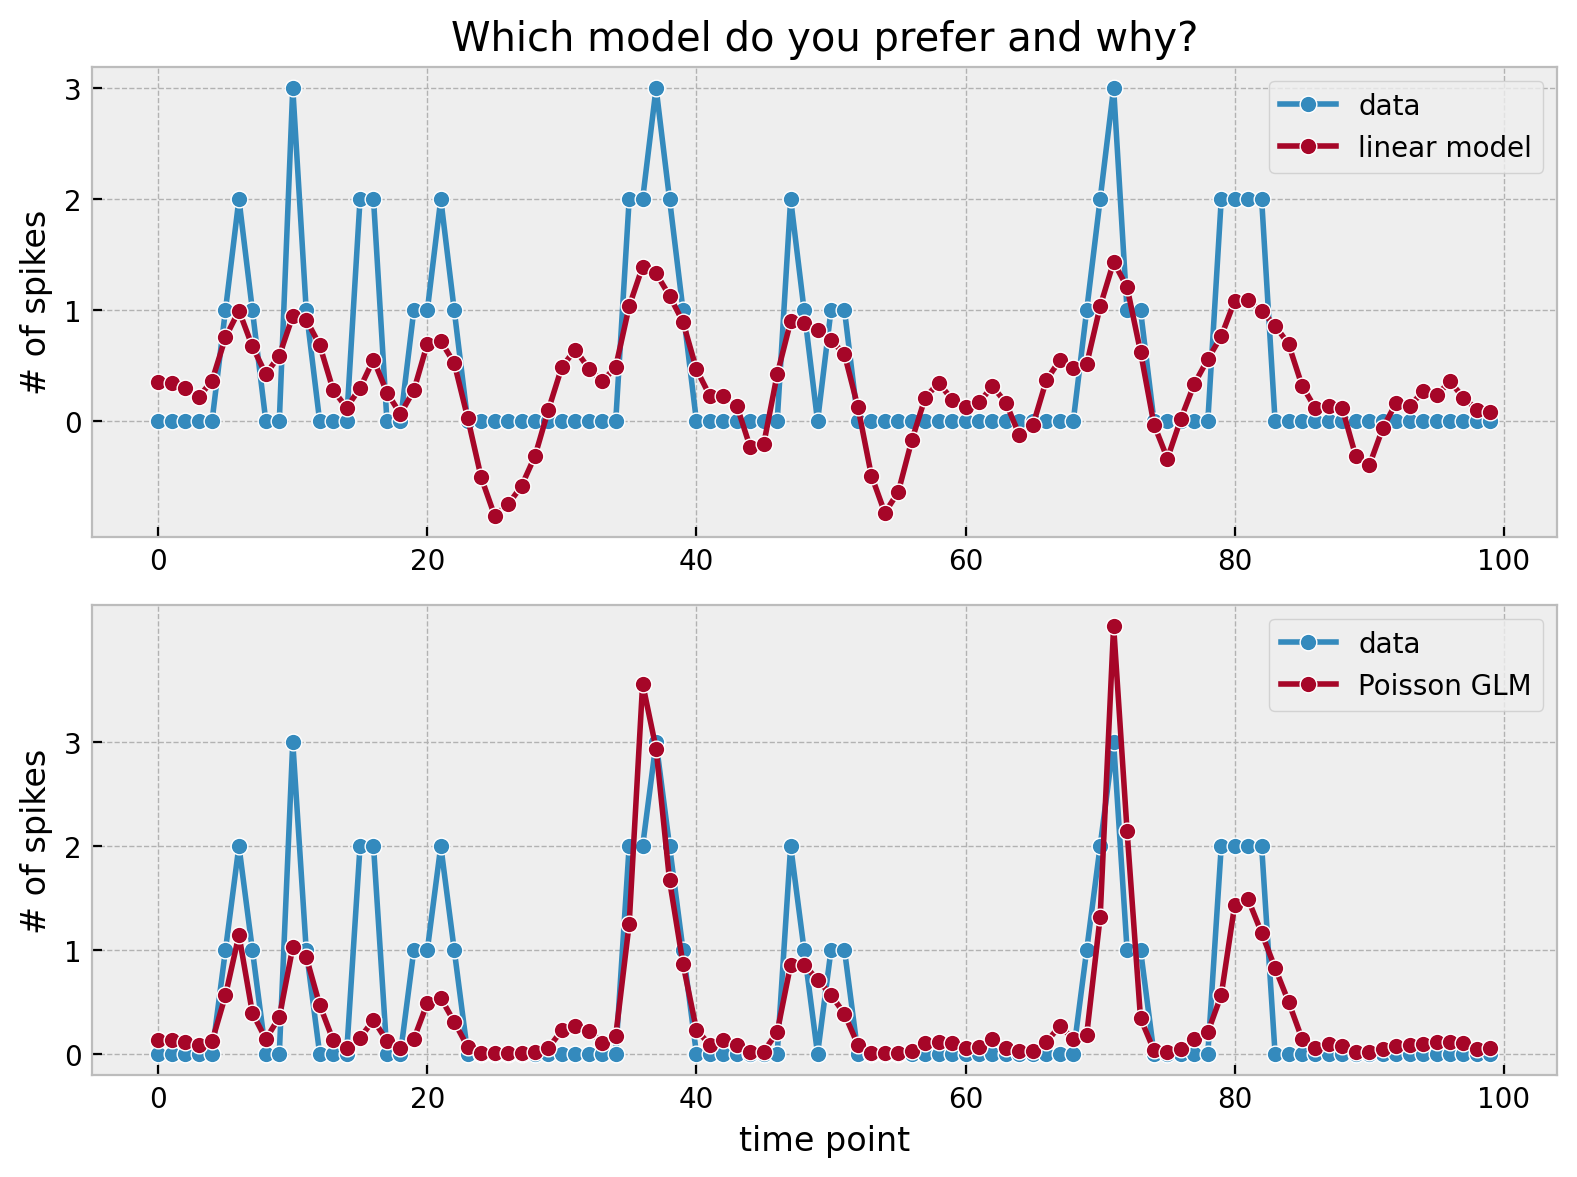

In [15]:
# linear model vs. poisson GLM spike count prediction
plt.subplot(211)
plt.plot(spikes[:100], 'o-', label='data')
plt.plot(lin_spikes[:100], 'o-', label='linear model')
plt.yticks(range(4))
plt.ylabel('# of spikes')
plt.title('Which model do you prefer and why?')
plt.legend()
plt.subplot(212)
plt.plot(spikes[:100], 'o-', label='data')
plt.plot(poisson_spikes[:100], 'o-', label='Poisson GLM')
plt.yticks(range(4))
plt.xlabel('time point')
plt.ylabel('# of spikes')
plt.legend()
plt.tight_layout();

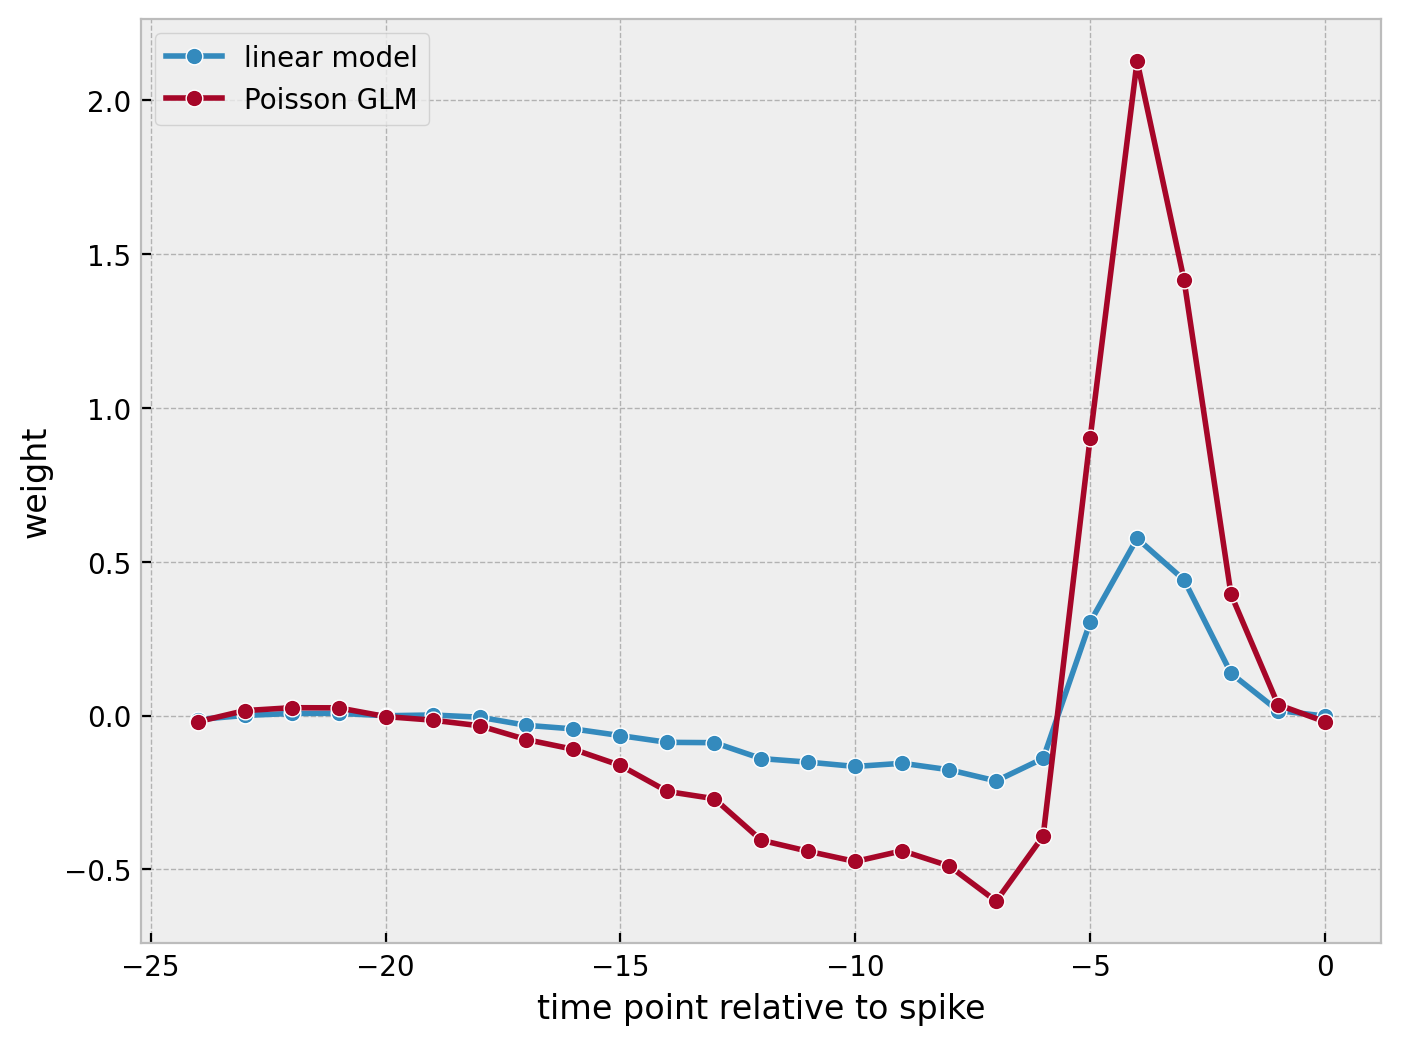

In [16]:
plt.plot(range(-24, 1), lin_model.coef_, 'o-', label='linear model')
plt.plot(range(-24, 1), poisson_model.coef_, 'o-', label='Poisson GLM')
plt.xlabel('time point relative to spike')
plt.ylabel('weight')
plt.legend();

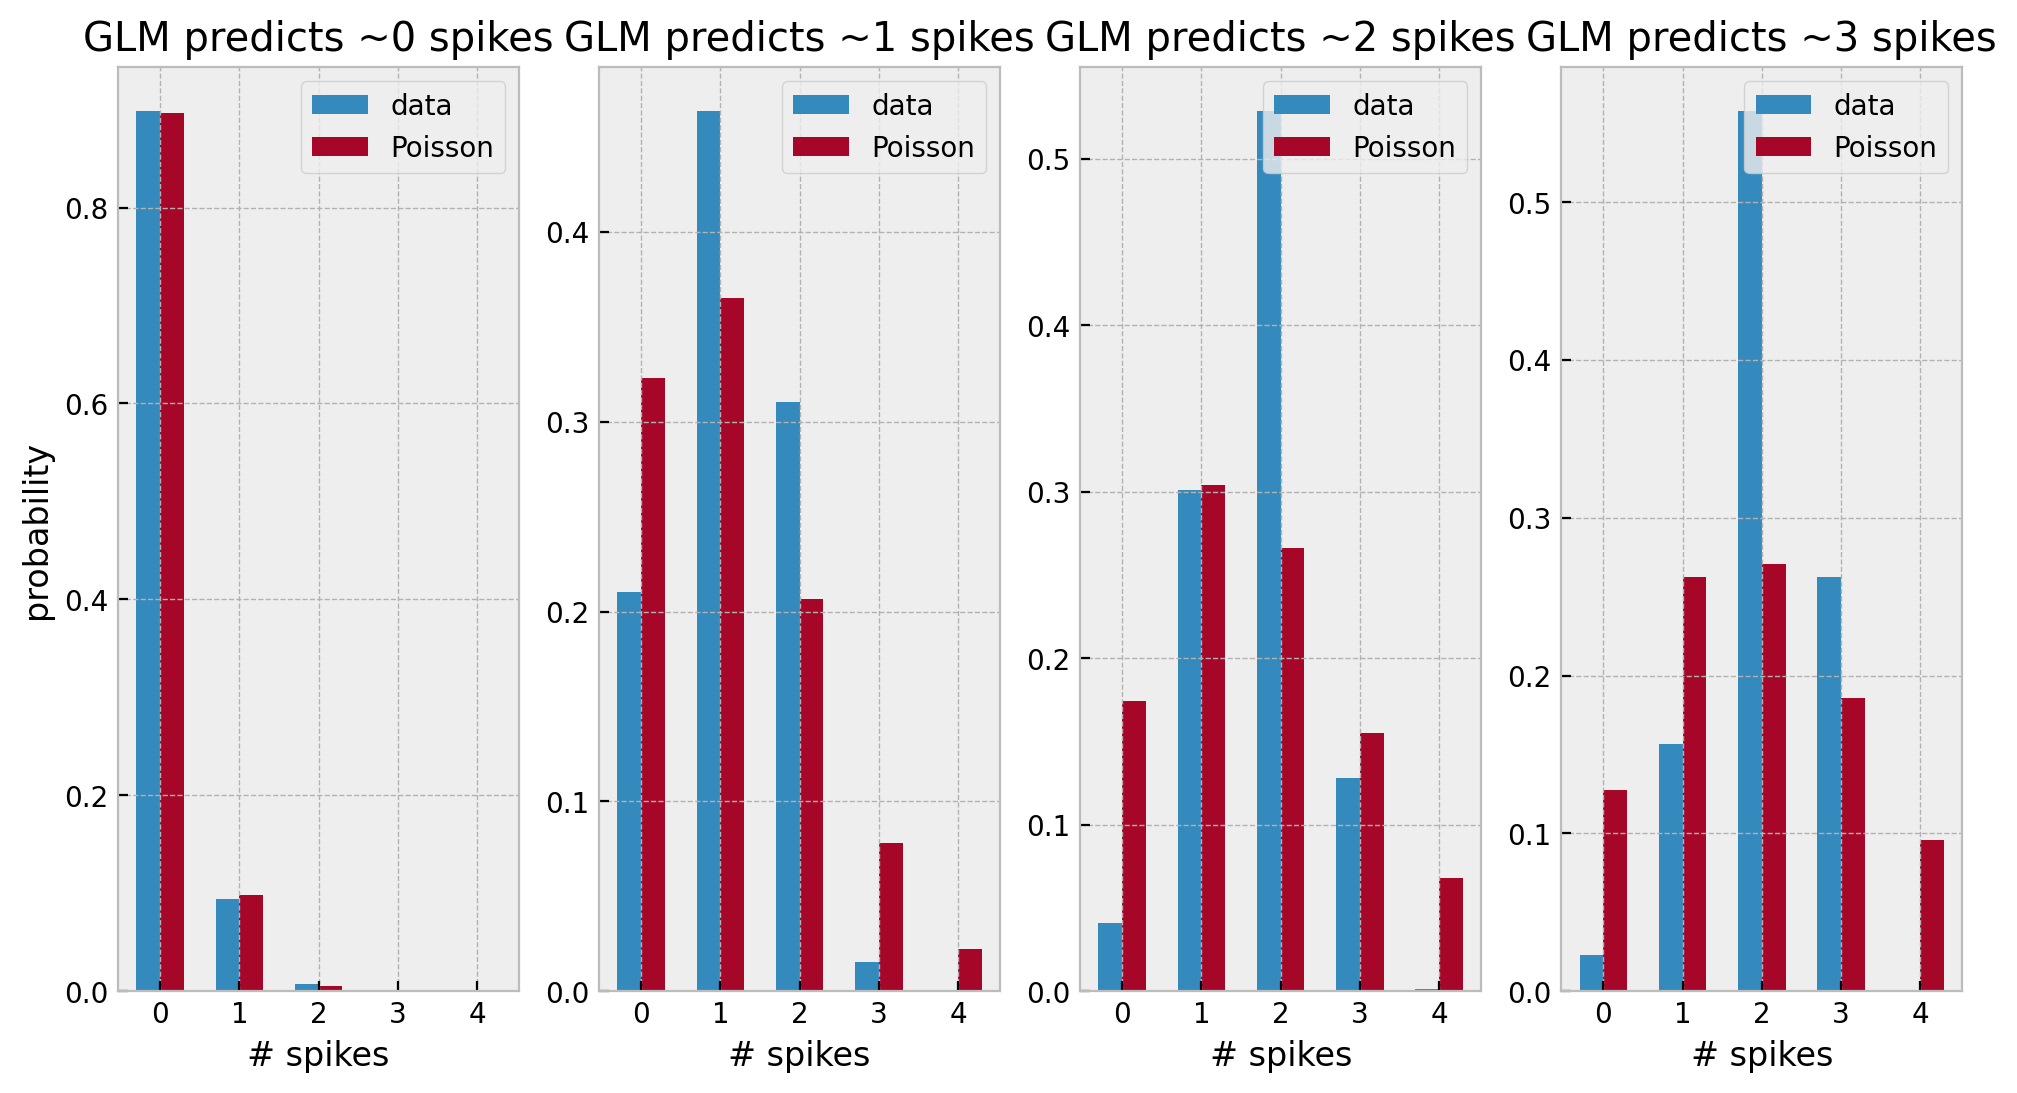

In [17]:
plt.figure(figsize=[15,6])
for i in range(4):
    ispikes = spikes[(poisson_spikes >= float(i) - 0.5) & (poisson_spikes < float(i) + 0.5)]
    
    bins = np.arange(5)
    bin_edges = np.arange(6) - 0.5
    counts = np.histogram(ispikes, bins=bin_edges, density=True)[0]
    
    pmf = st.poisson(ispikes.mean()).pmf(bins)
    
    plt.subplot(1, 5, i+1)
    plt.bar(bins-0.15, counts, width=0.3, label='data')
    plt.bar(bins+0.15, pmf, width=0.3, label='Poisson')
    plt.xticks(bins)
    plt.xlabel('# spikes')
    if i == 0:
        plt.ylabel('probability')
    plt.title(f"GLM predicts ~{i} spikes")
    plt.legend()

What does the above plot tell you about this Poisson GLM?

What response does the Poisson GLM spiking model predict for a step stimulus?

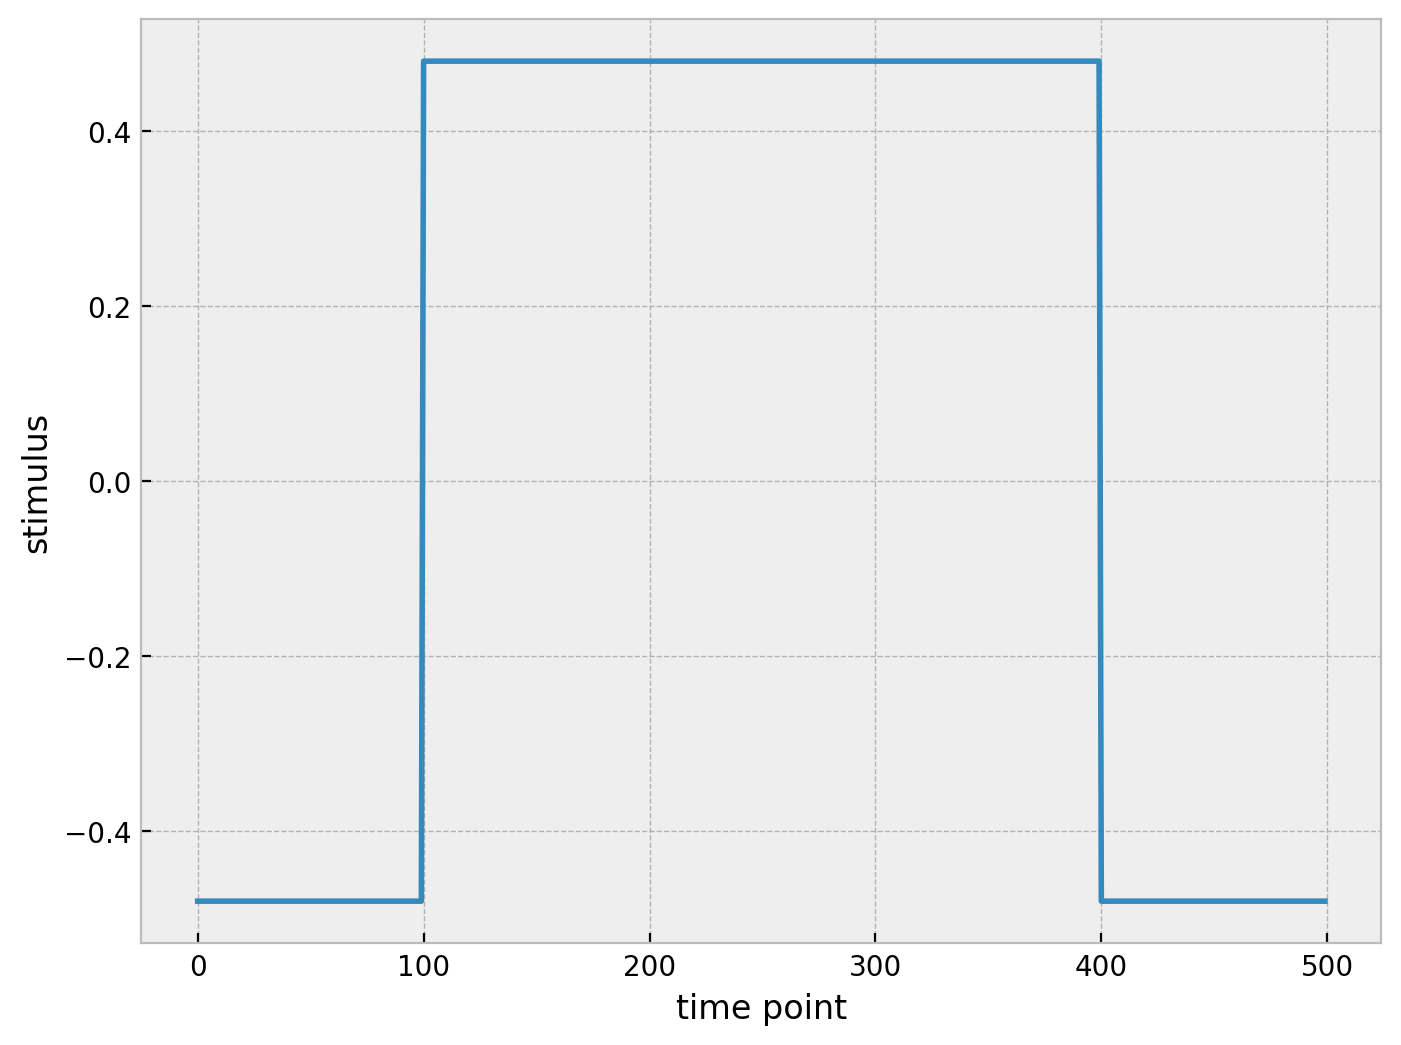

In [18]:
step_stimulus = np.ones(500) * -0.48
step_stimulus[100:400] = 0.48

plt.plot(step_stimulus)
plt.xlabel('time point')
plt.ylabel('stimulus');

Construct the feature matrix from the stimulus...

In [19]:
Xstep = stimulus_to_X(step_stimulus)

Use the feature matrix and your trained model to predict the spikes in response to the stimulus...

In [20]:
step_spikes = poisson_model.predict(Xstep)

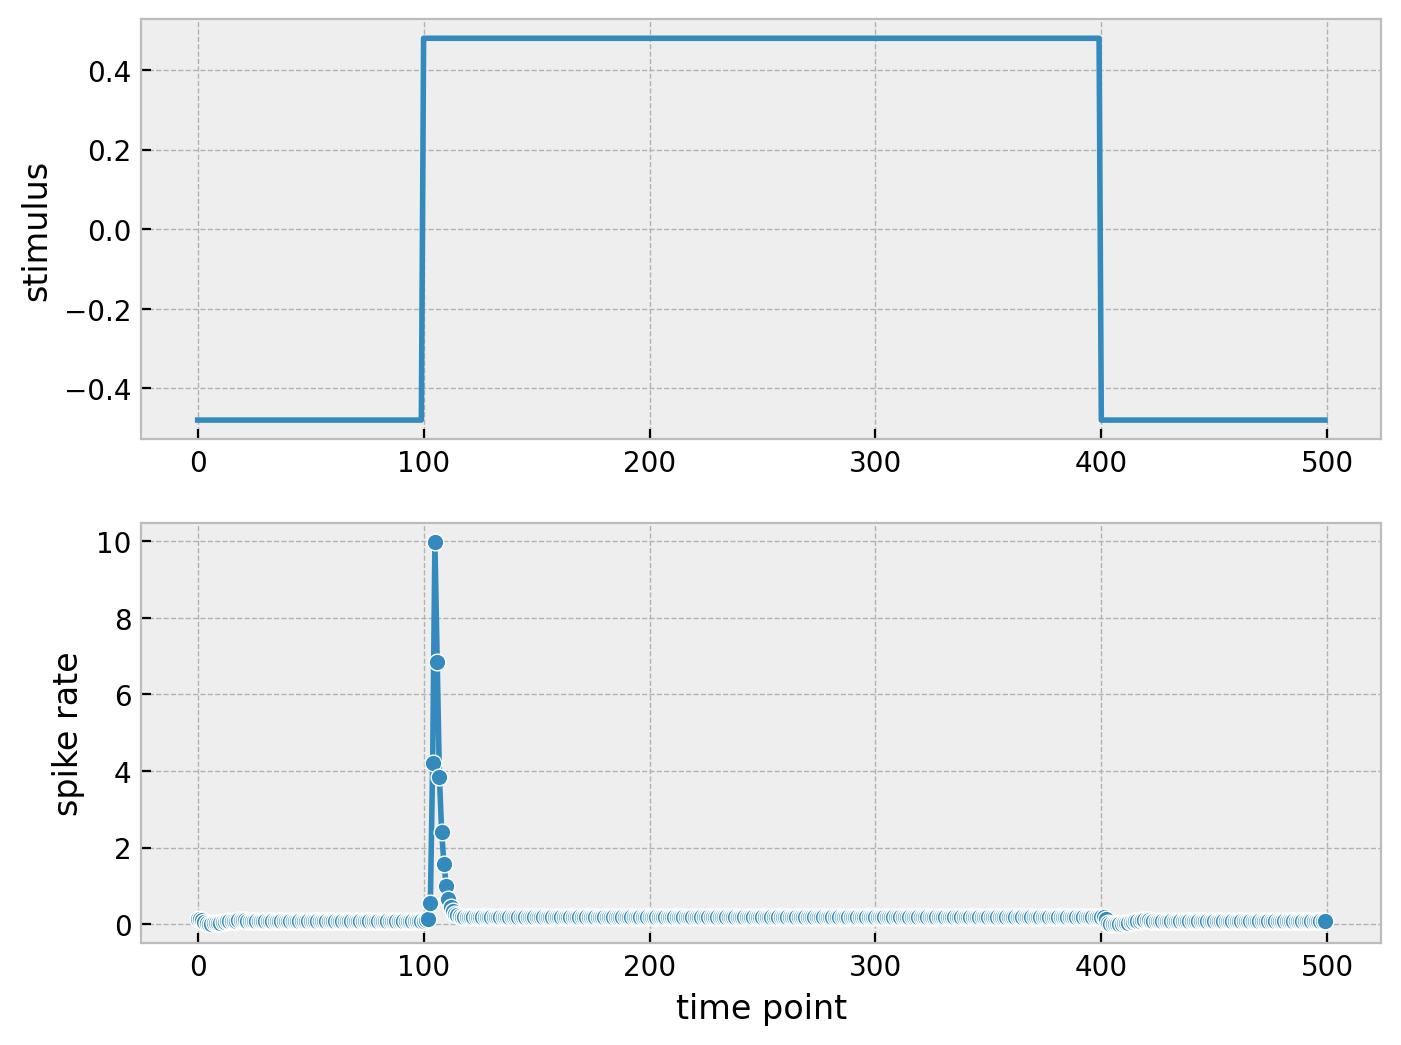

In [21]:
# step stimulus-response
plt.subplot(211)
plt.plot(step_stimulus)
plt.ylabel('stimulus')
plt.subplot(212)
plt.plot(step_spikes, 'o-')
plt.xlabel('time point')
plt.ylabel('spike rate');

### Exercise
Use the Poisson GLM spike rate model to predict a retinal ganglion cell response to an input that switches back and forth between OFF and ON every 25 time points (500 time points total).

In [22]:
# onoff_stimulus = np.array(([-0.48]*25 + [0.48]*25)*10)

# Xonoff = stimulus_to_X(onoff_stimulus)

# predicted_onoff_spikes = ...

# # on/off stimulus-response
# plt.subplot(211)
# plt.plot(onoff_stimulus)
# plt.ylabel('stimulus')
# plt.subplot(212)
# plt.plot(predicted_onoff_spikes, 'o-')
# plt.xlabel('time point')
# plt.ylabel('spike rate');

### Exercise key

Use the Poisson GLM spike rate model to predict a retinal ganglion cell response to an input that switches back and forth between OFF and ON every 25 time points (500 time points total).

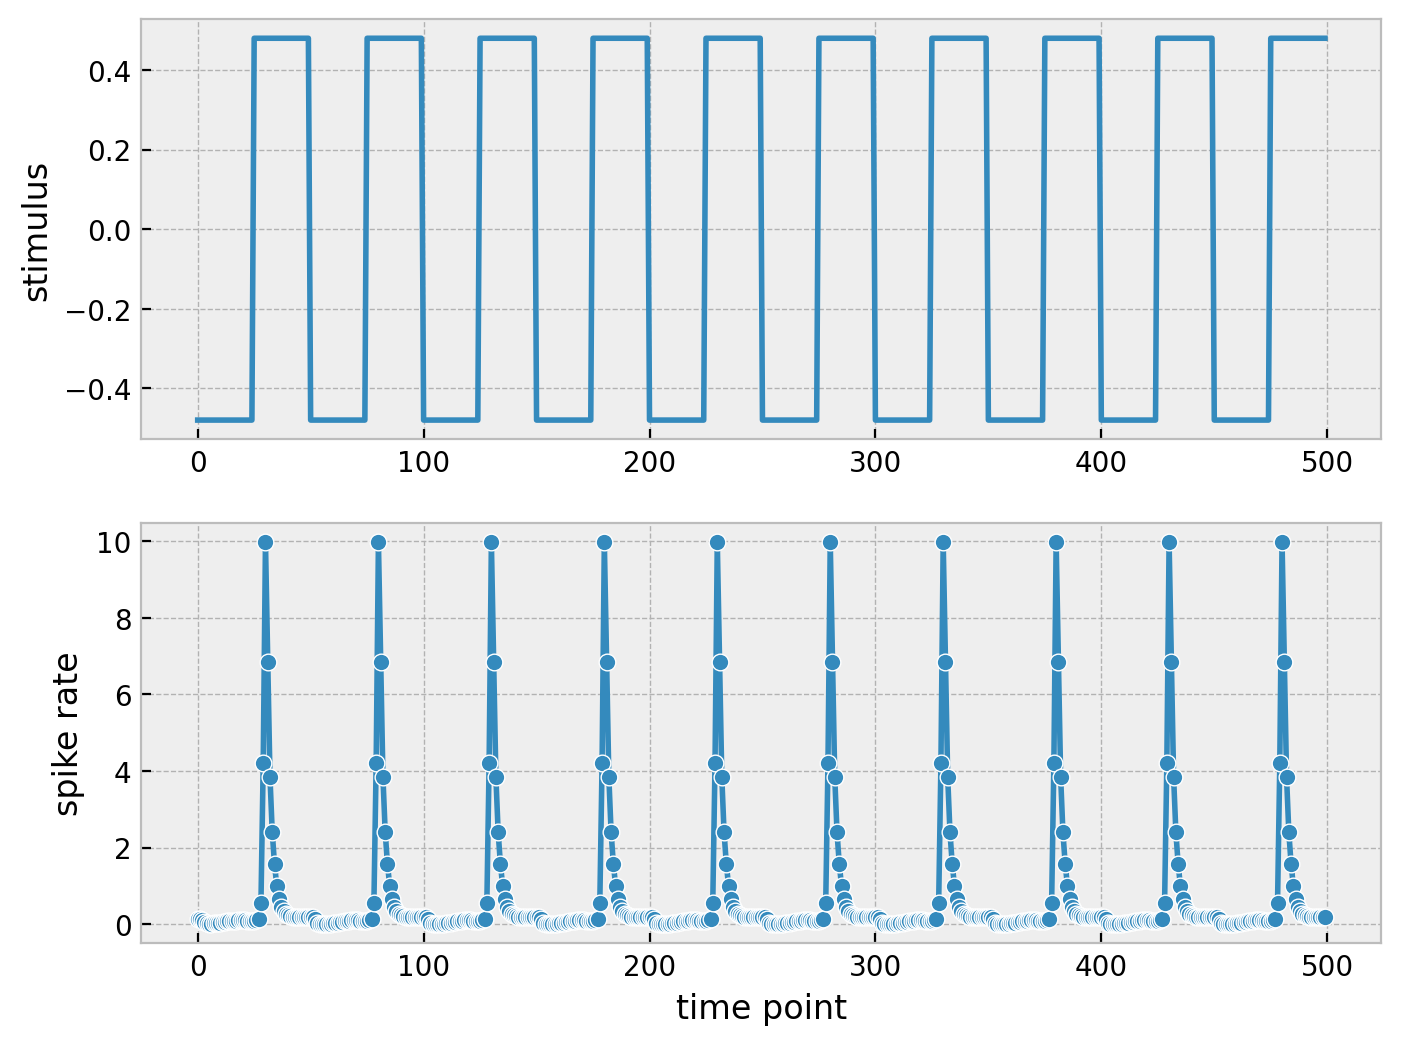

In [23]:
onoff_stimulus = np.array(([-0.48]*25 + [0.48]*25)*10)

Xonoff = stimulus_to_X(onoff_stimulus)

predicted_onoff_spikes = poisson_model.predict(Xonoff)

# on/off stimulus-response
plt.subplot(211)
plt.plot(onoff_stimulus)
plt.ylabel('stimulus')
plt.subplot(212)
plt.plot(predicted_onoff_spikes, 'o-')
plt.xlabel('time point')
plt.ylabel('spike rate');

### Mouse choice task

Consider the following task from [Steinmetz et al. (2019)](https://www.nature.com/articles/s41586-019-1787-x): For a repeated series of trials, a mouse is trained to rotate a wheel to indicate whether it perceives a Gabor pattern to the left or right. Spike rates from many cortical neurons are recorded on each trial. The goal is to build a model that can predict the mouse's choice based on the spiking of its cortical neurons.

![](images/gabor.png)

Adapted from [Neuromatch Academy](https://compneuro.neuromatch.io/tutorials/W1D4_GeneralizedLinearModels/student/W1D4_Tutorial2.html)

### Question

Is a linear model appropriate in this case?

Why or why not?

Load the data:

* `choices`: mouse chooses whether a Gabor stimulus is to the left or right on each of 276 trials 
* `spikes`: normalized spike rates for each of 691 neurons across the cortex recorded with Neuropixel probes on each trial

In [24]:
spikes = np.load('data/mouse_cortical_spiking.npy')
choices = np.load('data/mouse_left_right_choices.npy')

spikes.shape, choices.shape

((276, 691), (276,))

In [25]:
# 0 = left, 1 = right
choices[:9]

array([1., 1., 0., 0., 0., 0., 1., 0., 0.])

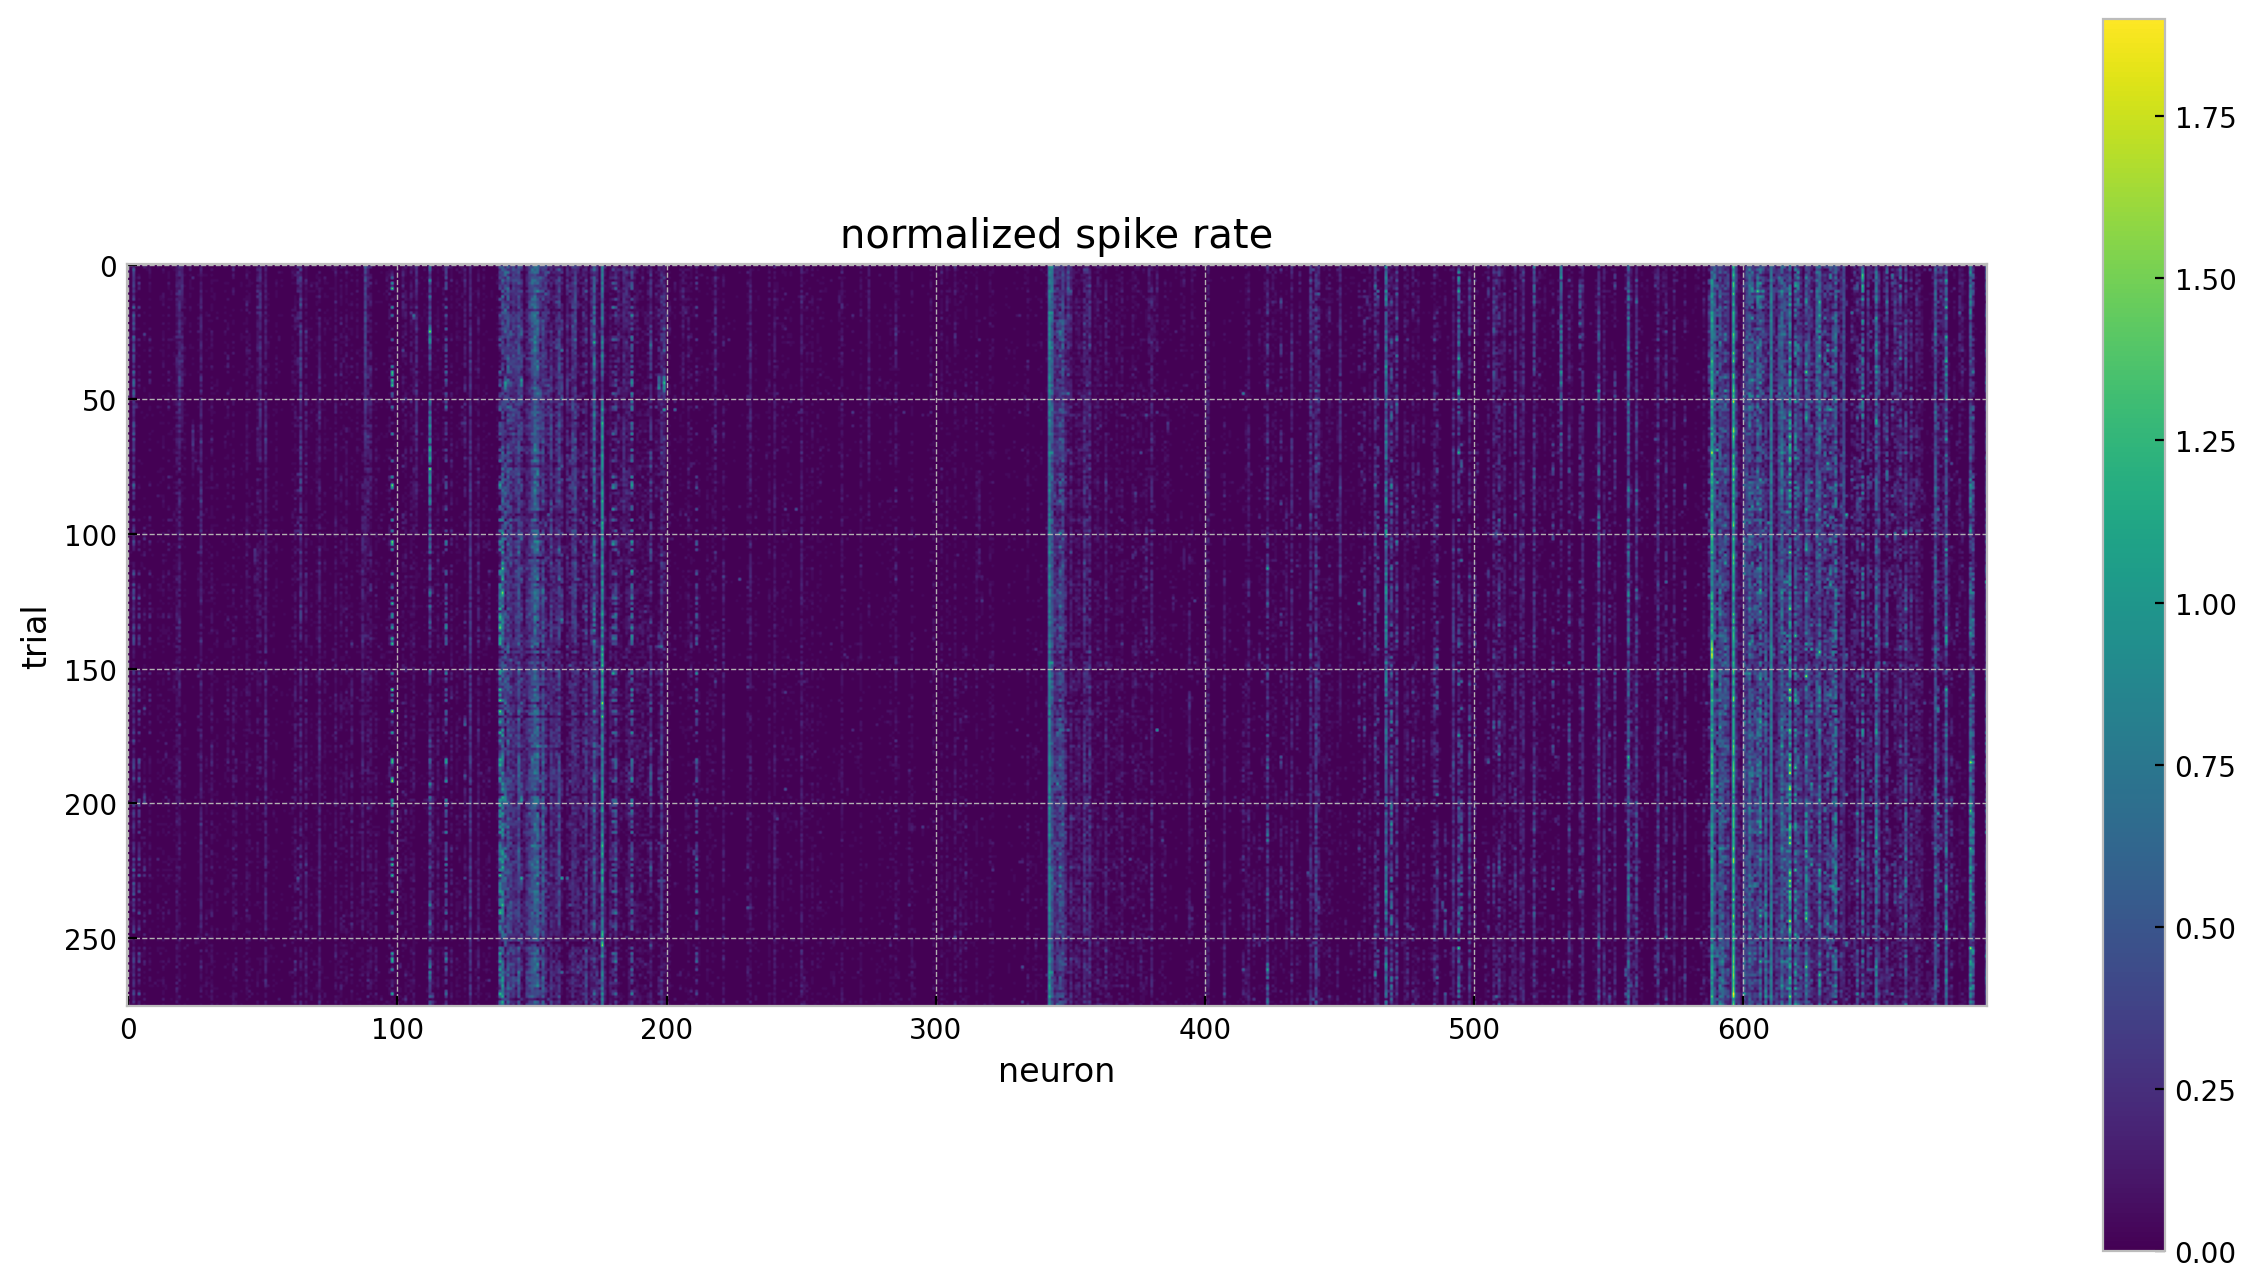

In [26]:
plt.figure(figsize=[15,8])
plt.imshow(spikes)
plt.xlabel('neuron')
plt.ylabel('trial')
plt.title('normalized spike rate');
plt.colorbar();

### Exercise

Use a logistic regression (Bernoulli GLM) to predict the mouse's choice based on its cortical activity.

In [27]:
# from sklearn.linear_model import LogisticRegression

# penalty is a regularization strength
# logreg_model = LogisticRegression(penalty='none')

# # fit the model to the data
# X = ...
# y = ...
# logreg_model.fit(X, y)

# # predict the mouse's choice based on its cortical activity
# logreg_choices = ...

# Exercise Key

Use a logistic regression (Bernoulli GLM) to predict the mouse's choice based on its cortical activity.

In [28]:
from sklearn.linear_model import LogisticRegression

# penalty is a regularization strength
logreg_model = LogisticRegression(penalty=None)

# fit the model to the data
X = spikes
y = choices
logreg_model.fit(X, y)

# predict the mouse's choice based on its cortical activity
logreg_choices = logreg_model.predict(X)

How well did the model do?

In [29]:
# accuracy = % correct
accuracy = (choices == logreg_choices).mean()

accuracy

1.0

But an accuracy of 100% seems too good to be true?

We'll come back to this in a bit...

Which neurons are associated with choosing left vs. right?

Which neurons have little influence on the choice?

In [30]:
logreg_model.coef_.shape

(1, 691)

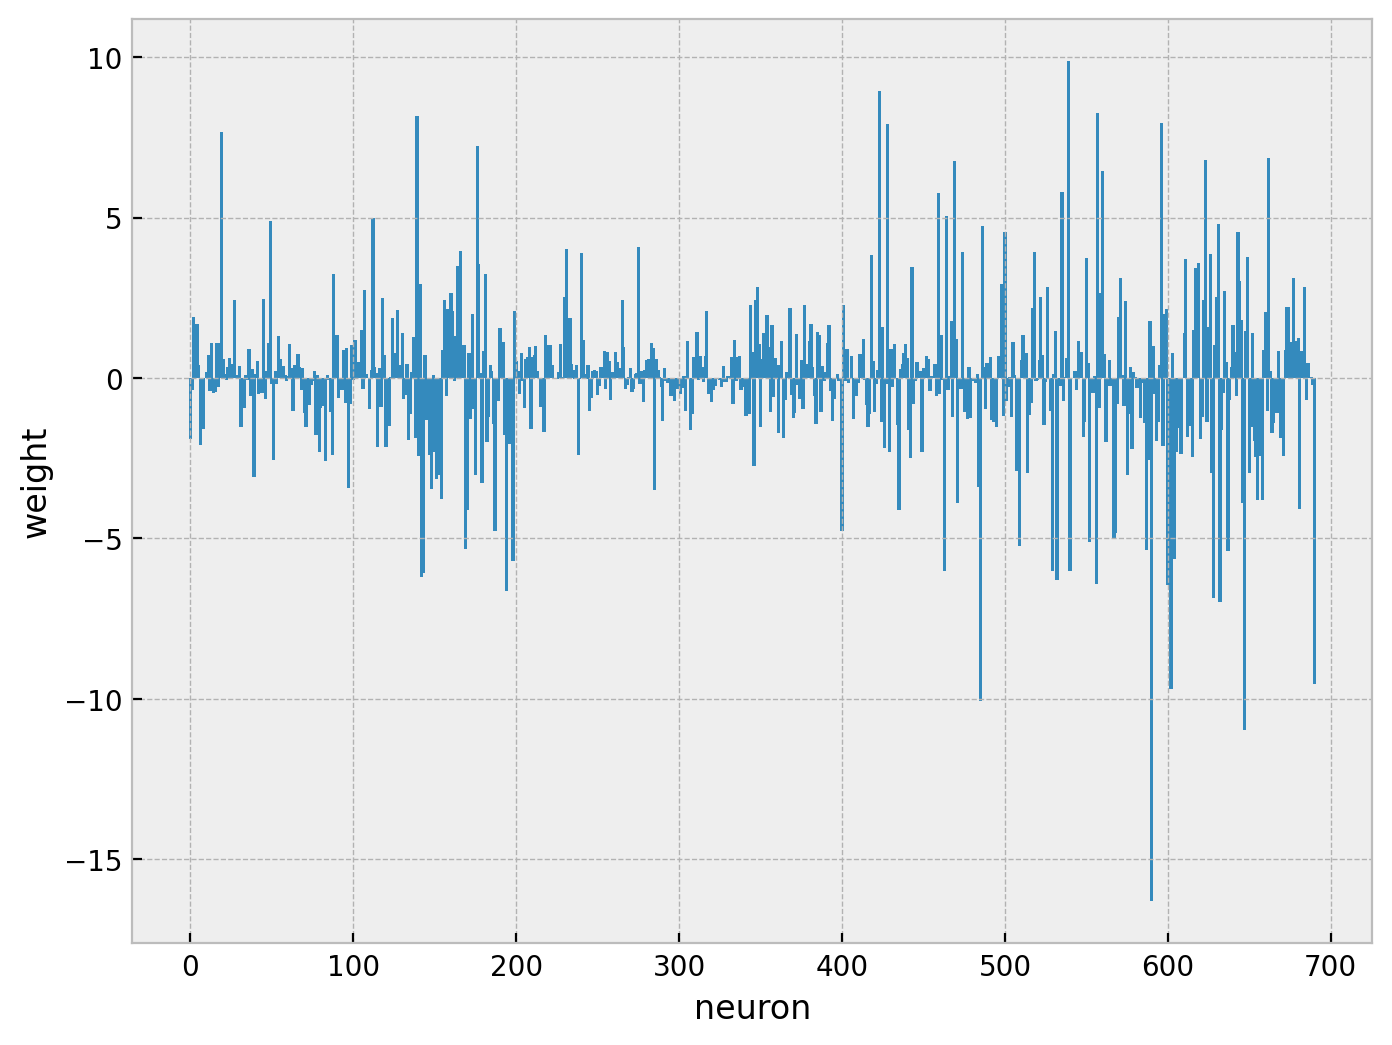

In [31]:
plt.bar(np.arange(691), logreg_model.coef_.reshape([-1]), width=2)
plt.xlabel('neuron')
plt.ylabel('weight');

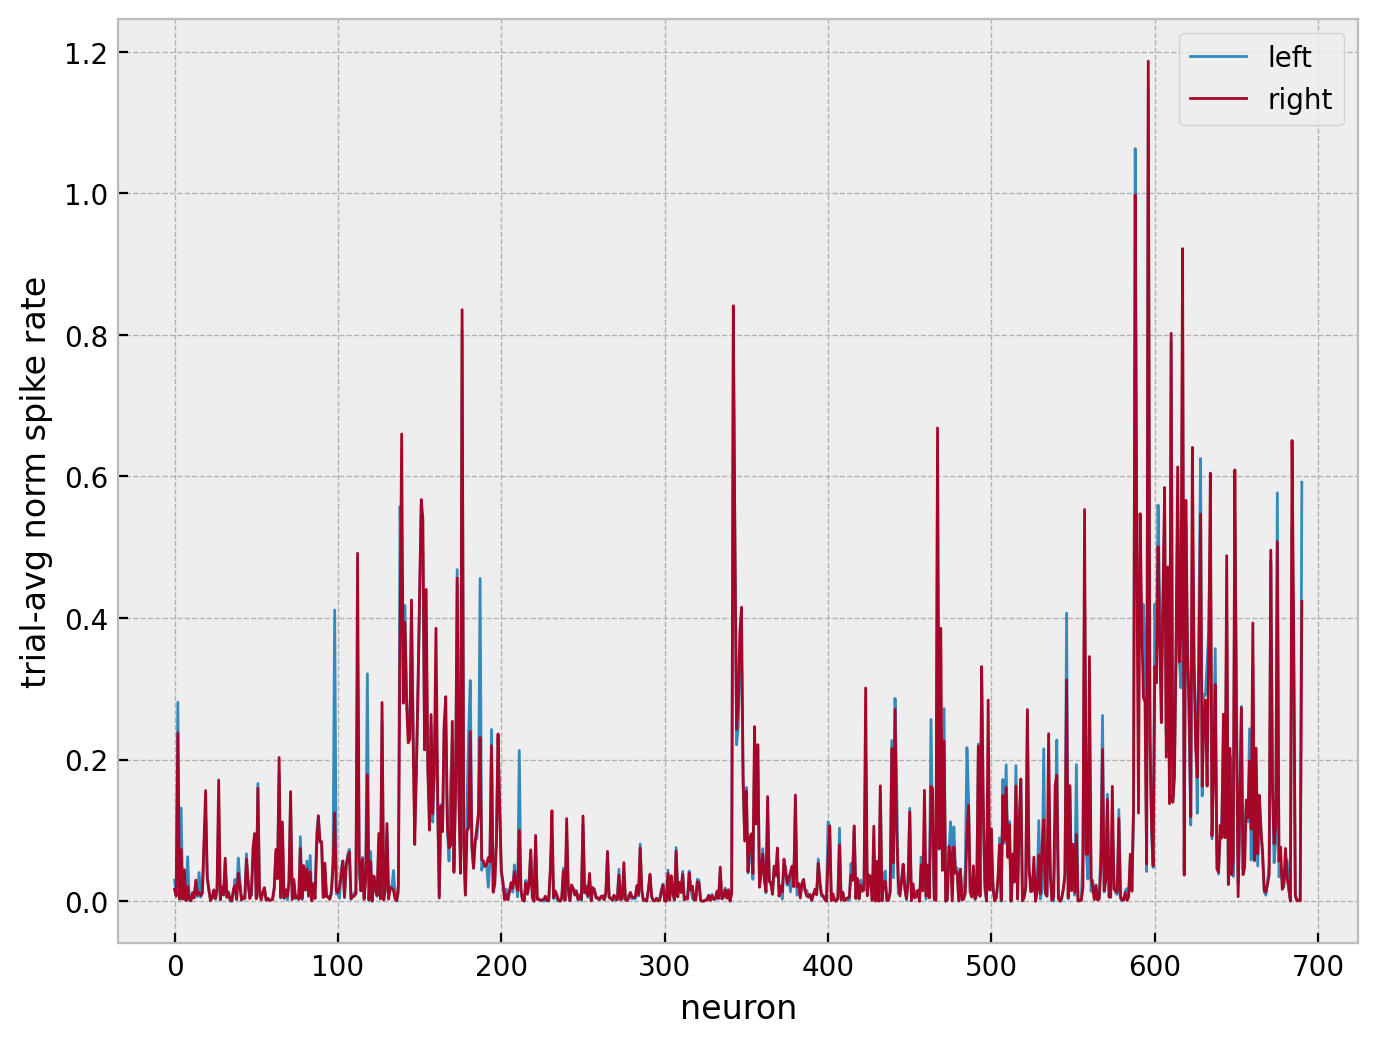

In [32]:
# spikes[trials, neurons]
trialavg_spikes_left = spikes[choices == 0,:].mean(axis=0)
trialavg_spikes_right = spikes[choices == 1,:].mean(axis=0)

plt.plot(trialavg_spikes_left, lw=1, label='left')
plt.plot(trialavg_spikes_right, lw=1, label='right')
plt.xlabel('neuron')
plt.ylabel('trial-avg norm spike rate')
plt.legend();

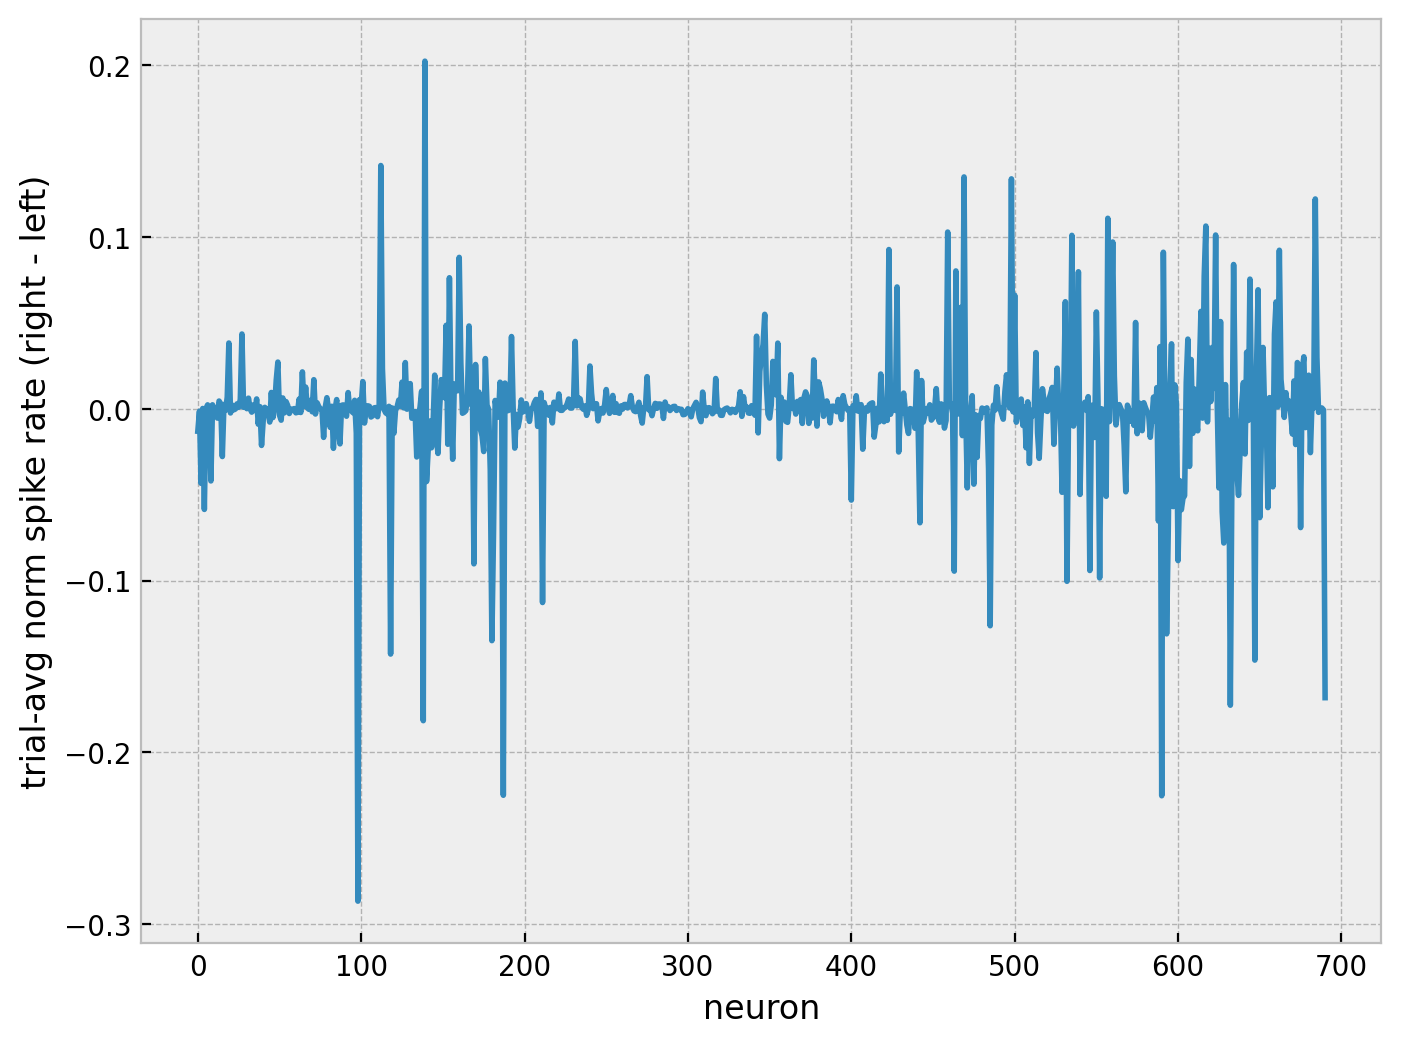

In [33]:
plt.plot(trialavg_spikes_right - trialavg_spikes_left)
plt.xlabel('neuron')
plt.ylabel('trial-avg norm spike rate (right - left)');

### Exercise

Predict the mouses choice on two new trials given the normalized spike rates for the neurons on each trial.

In [34]:
# # spikes for two new trials
# spikes1 = 0.8 * trialavg_spikes_right + 0.2 * trialavg_spikes_left
# spikes2 = 0.3 * trialavg_spikes_right + 0.7 * trialavg_spikes_left

# # new feature matrix has two rows (one for each trial)
# Xnew = np.vstack([spikes1, spikes2])

# # predict the new choices
# new_choices = ...

# new_choices

### Exercise Key

Predict the mouses choice on two new trials given the normalized spike rates for the neurons on each trial.

In [38]:
# spikes for two new trials
spikes1 = 0.8 * trialavg_spikes_right + 0.2 * trialavg_spikes_left
spikes2 = 0.3 * trialavg_spikes_right + 0.7 * trialavg_spikes_left

# new feature matrix has two rows (one for each trial)
Xnew = np.vstack([spikes1, spikes2])

# predict the new choices
new_choices = logreg_model.predict(Xnew)

Xnew.shape, new_choices

((2, 691), array([1., 0.]))

Recall that the model had an acuracy of 100% on the training data, which seems too good to be true.

If it is, what might be going on?

Let's start by applying some regularization to keep the model parameters from exploding in order to fit noise in the data.

In [39]:
# apply a ridge (L2) regularization penalty (C = 1/alpha)
# !!! Note that this is the default!
logreg_model = LogisticRegression(penalty='l2', C=1)

# fit the model to the data
X = spikes
y = choices
logreg_model.fit(X, y)

# predict the mouse's choice based on its cortical activity
logreg_choices = logreg_model.predict(X)

# accuracy = % correct
accuracy = (choices == logreg_choices).mean()
accuracy

0.9782608695652174

But this is still not a great measure of how accurate the model will be when applied to data it was not trained on.

To get a better sense of the model's accuracy for new data, we could either test its accuracy on a withheld test set or get its cross validated accuracy on the training set.

In [41]:
from sklearn.model_selection import cross_val_score

# the model (same as before)
logreg_model = LogisticRegression(penalty='l2', C=1)

# the data (same as before)
X = spikes
y = choices

# cross validated accuracy for each of 5 folds
cv_accuracy = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')
cv_accuracy

array([0.83928571, 0.85454545, 0.87272727, 0.87272727, 0.85454545])

This is a much more realistic measure of our model's accuracy.

In [42]:
best_estimate_of_accuracy = np.mean(cv_accuracy)
best_estimate_of_accuracy

0.8587662337662337

But did we choose the most optimal regularization strength?

### Exercise
Find the optimal regularization strength using cross validation.

In [43]:
# from sklearn.model_selection import GridSearchCV

# # the model (regularization strength not defined here, it will be a parameter of the search)
# logreg_model = LogisticRegression(penalty='l2')

# # the search parameter space (C = 1/alpha)
# params = {'C': np.linspace(0.1, 1, 100)}

# # setup the search
# search = ...

# # do the search
# ...

# # selected model
# logreg_model = search.best_estimator_
# logreg_model

### Exercise key
Find the optimal regularization strength using cross validation.

In [44]:
from sklearn.model_selection import GridSearchCV

# the model (regularization strength not defined here, it will be a parameter of the search)
logreg_model = LogisticRegression(penalty='l2')

# the search parameter space (C = 1/alpha)
params = {'C': np.linspace(0.1, 1, 100)}

# setup the search
search = GridSearchCV(logreg_model, params)

# do the search
search.fit(X, y)

# selected model
logreg_model = search.best_estimator_
logreg_model

LogisticRegression(C=0.5545454545454546)

Cross validated accuracy of the selected model.

In [45]:
# cross validated accuracy for each of 5 folds
cv_accuracy = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')
cv_accuracy

array([0.82142857, 0.85454545, 0.87272727, 0.89090909, 0.85454545])

In [46]:
best_estimate_of_accuracy = np.mean(cv_accuracy)
best_estimate_of_accuracy

0.8588311688311687

What about adding a regularization strength to the Poisson GLM model predicting spikes in response to a stimulus?

In [47]:
# data from Jonathan Pillow's lab: https://github.com/pillowlab/GLMspiketraintutorial
stimulus = np.load('data/retinal_ganglion_stimulus.npy')
spikes = np.load('data/retinal_ganglion_spikes.npy')

stimulus.shape, spikes.shape

((20000,), (20000,))

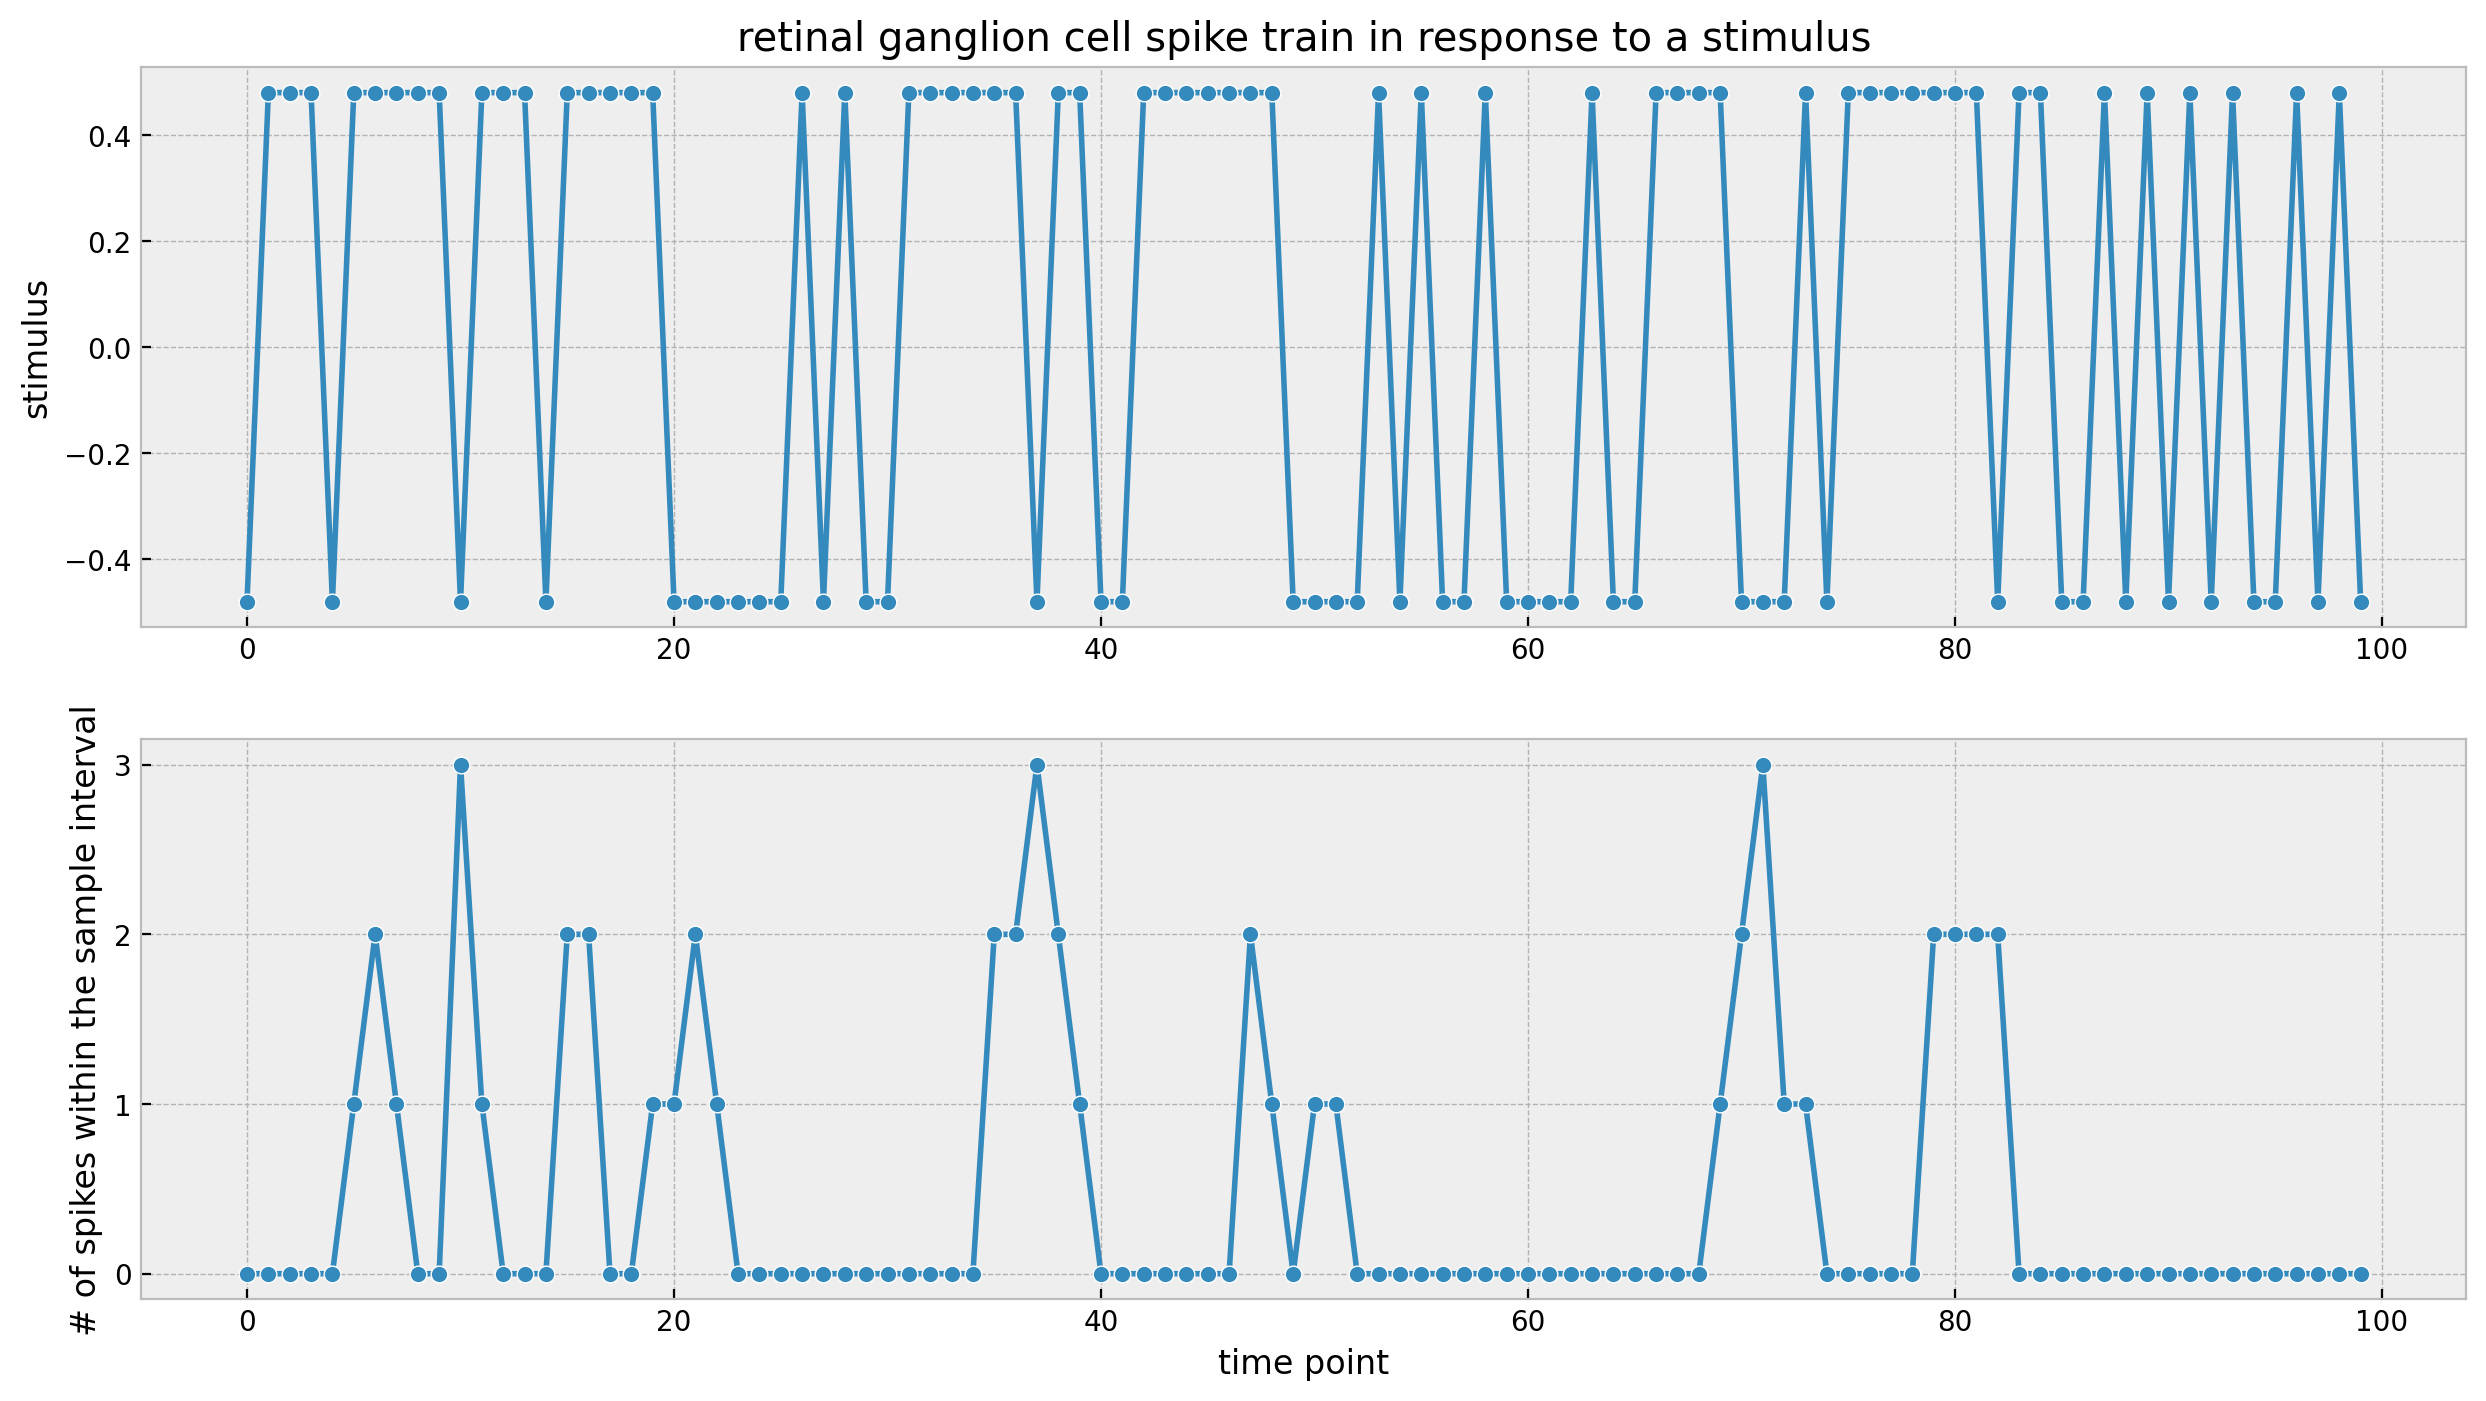

In [48]:
# retinal ganglion stimulus and spike data
plt.figure(figsize=[15,8])
plt.subplot(211)
plt.plot(stimulus[:100], 'o-')
plt.ylabel('stimulus')
plt.title('retinal ganglion cell spike train in response to a stimulus')
plt.subplot(212)
plt.plot(spikes[:100], 'o-')
plt.yticks(range(4))
plt.ylabel('# of spikes within the sample interval')
plt.xlabel('time point');

Transform the stimulus into a feature matrix X where each row is using the stimulus from the preceeding 25 time points to predict the current time point.

In [49]:
X = stimulus_to_X(stimulus)
y = spikes

X.shape, y.shape

((20000, 25), (20000,))

<img src="images/X-linear-receptive-field-last.drawio.svg" width="50%">

### Exercise
Find the optimal regularization strength using cross validation.

In [50]:
# # model (regularization strength is not specified here, it is a search parameter)
# poisson_model = PoissonRegressor()

# # search parameter space
# params = {'alpha': np.logspace(-5, -3, 50)}

# # setup the search
# search = ...

# # do the search
# ...

# # selected model
# poisson_model = search.best_estimator_
# poisson_model

### Exercise key
Find the optimal regularization strength using cross validation.

In [51]:
# model (regularization strength is not specified here, it is a search parameter)
# !!! The default is Ridge regularization with alpha = 1
poisson_model = PoissonRegressor()

# search parameter space
params = {'alpha': np.logspace(-5, -3, 50)}

# setup the search
search = GridSearchCV(poisson_model, params)

# do the search
search.fit(X, y)

# selected model
poisson_model = search.best_estimator_
poisson_model

PoissonRegressor(alpha=0.00029470517025518097)

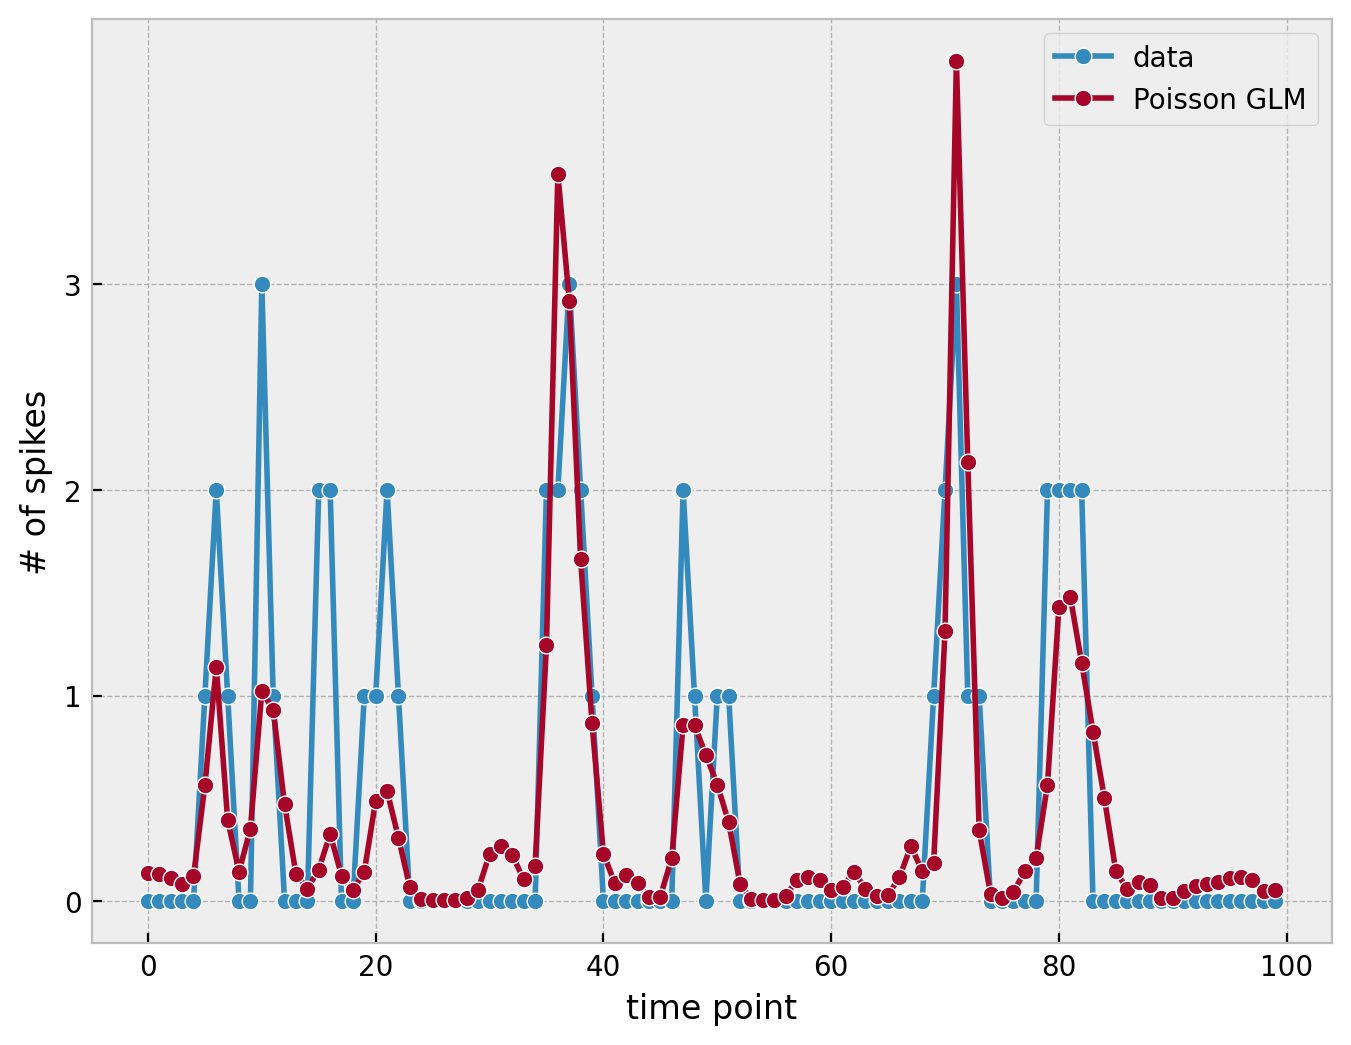

In [52]:
# predict the spike counts based on the stimulus
poisson_spikes = poisson_model.predict(X)

# plot model prediction over data
plt.plot(spikes[:100], 'o-', label='data')
plt.plot(poisson_spikes[:100], 'o-', label='Poisson GLM')
plt.yticks(range(4))
plt.xlabel('time point')
plt.ylabel('# of spikes')
plt.legend();